In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from collections import Counter
import random
import time
from sklearn.model_selection import (cross_val_score, StratifiedKFold, KFold, 
                                     GridSearchCV, RandomizedSearchCV, train_test_split)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

import lightgbm as lgb
from lightgbm import LGBMClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')


## ACO

In [22]:
# =============================================================================
# CLASS 1: ACO FEATURE SELECTION
# =============================================================================

class ACOFeatureSelection:
    """
    Ant Colony Optimization for Feature Selection
    """
    
    def __init__(self, n_features, n_ants=10, max_iter=20, alpha=1, beta=2, rho=0.5):
        self.n_features = n_features
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha  # pheromone importance
        self.beta = beta    # heuristic importance
        self.rho = rho      # pheromone evaporation rate

        # Initialize pheromone trails
        self.pheromone = np.ones((n_features, n_features))
        self.best_subset = None
        self.best_score = float('inf')  # Using MSE, so lower is better
        self.best_accuracy = 0  # Lưu lại độ chính xác tốt nhất
        self.history = []  # Lưu lại lịch sử cho việc vẽ biểu đồ sau này

    def fit(self, X_train, y_train, X_test, y_test, classifier=None):
        # Initialize classifier (using KNN as in the paper)
        if classifier is None:
            classifier = KNeighborsClassifier(n_neighbors=5)

        for iteration in range(self.max_iter):
            all_subsets = []
            all_scores = []
            all_accuracies = []

            # Each ant constructs a solution
            for ant in range(self.n_ants):
                # Randomly select initial feature
                current_feature = random.randint(0, self.n_features - 1)
                visited = [current_feature]
                unvisited = list(set(range(self.n_features)) - set(visited))

                # Continue adding features until stopping criterion is met
                stagnation_counter = 0
                current_score = float('inf')
                current_accuracy = 0

                while unvisited and stagnation_counter < 3:  # As in the paper, stop after 3 non-improving steps
                    # Calculate probabilities for next feature
                    probabilities = self._calculate_probabilities(current_feature, visited, unvisited)

                    # Select next feature
                    next_feature = self._select_next_feature(probabilities, unvisited)
                    visited.append(next_feature)
                    unvisited.remove(next_feature)

                    # Evaluate current subset
                    selected_features = visited.copy()
                    
                    # Handle either DataFrame or numpy array
                    if hasattr(X_train, 'iloc'):  # Pandas DataFrame
                        X_train_selected = X_train.iloc[:, selected_features]
                        X_test_selected = X_test.iloc[:, selected_features]
                    else:  # Numpy array
                        X_train_selected = X_train[:, selected_features]
                        X_test_selected = X_test[:, selected_features]

                    classifier.fit(X_train_selected, y_train)
                    y_pred = classifier.predict(X_test_selected)
                    score = mean_squared_error(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)

                    # Check if current subset improves performance
                    if score < current_score:
                        current_score = score
                        current_accuracy = accuracy
                        stagnation_counter = 0
                    else:
                        stagnation_counter += 1

                    # Update current feature
                    current_feature = next_feature

                # Save the subset and its score
                all_subsets.append(visited)
                all_scores.append(current_score)
                all_accuracies.append(current_accuracy)

                # Update best global solution
                if current_score < self.best_score:
                    self.best_score = current_score
                    self.best_accuracy = current_accuracy
                    self.best_subset = visited.copy()

            # Update pheromone trails
            self._update_pheromone(all_subsets, all_scores)
            
            # Lưu thông tin lịch sử
            self.history.append({
                'iteration': iteration,
                'best_score': self.best_score,
                'best_accuracy': self.best_accuracy,
                'n_features': len(self.best_subset)
            })

            print(f"Iteration {iteration+1}/{self.max_iter}, Best MSE: {self.best_score:.4f}, "
                  f"Best Accuracy: {self.best_accuracy:.4f}, "
                  f"Features: {len(self.best_subset)}/{self.n_features}")

        return self.best_subset, self.best_score, self.best_accuracy

    def _calculate_probabilities(self, current_feature, visited, unvisited):
        probabilities = {}

        for feature in unvisited:
            # Pheromone between current feature and candidate feature
            tau = self.pheromone[current_feature, feature]

            # Heuristic information (inverse of feature index for simplicity)
            # In a real implementation, this would use classifier performance
            eta = 1.0 / (feature + 1)

            probabilities[feature] = (tau ** self.alpha) * (eta ** self.beta)

        # Normalize probabilities
        total = sum(probabilities.values())
        if total > 0:
            for feature in probabilities:
                probabilities[feature] /= total

        return probabilities

    def _select_next_feature(self, probabilities, unvisited):
        # Roulette wheel selection
        r = random.random()
        cumulative_prob = 0

        for feature in unvisited:
            cumulative_prob += probabilities.get(feature, 0)
            if r <= cumulative_prob:
                return feature

        # If no feature was selected, pick a random one
        return random.choice(unvisited)

    def _update_pheromone(self, all_subsets, all_scores):
        # Evaporate pheromone
        self.pheromone *= (1 - self.rho)

        # Add new pheromone
        for subset, score in zip(all_subsets, all_scores):
            # Normalize the score (lower MSE is better)
            normalized_score = 1.0 / (score + 1e-10)

            # Update pheromone for edges in the subset
            for i in range(len(subset) - 1):
                self.pheromone[subset[i], subset[i+1]] += normalized_score
                self.pheromone[subset[i+1], subset[i]] += normalized_score  # Symmetric update
                
    def get_feature_importance(self, feature_names=None):
        """
        Trả về tầm quan trọng của các đặc trưng được chọn dựa trên thứ tự chọn
        """
        if not self.best_subset:
            return {}
            
        importance_dict = {}
        for i, feature_idx in enumerate(self.best_subset):
            # Đặc trưng được chọn sớm hơn sẽ quan trọng hơn
            importance_value = len(self.best_subset) - i
            
            if feature_names and feature_idx < len(feature_names):
                importance_dict[feature_names[feature_idx]] = importance_value
            else:
                importance_dict[feature_idx] = importance_value
                
        return importance_dict
# Hàm tải dữ liệu
def load_data(file_path, sample_size=None):
    """Tải dữ liệu từ CSV"""
    print(f"Đang tải dữ liệu từ {file_path}...")
    data = pd.read_csv(file_path)
    
    print(f"Dữ liệu có {data.shape[0]} hàng và {data.shape[1]} cột")
    
    # Nếu cần lấy mẫu nhỏ hơn
    if sample_size and sample_size < len(data):
        print(f"Lấy mẫu {sample_size} dòng...")
        data = data.sample(sample_size, random_state=42)
    
    return data
# Hàm đánh giá tất cả đặc trưng
def evaluate_full_features(X_train, X_test, y_train, y_test):
    """Đánh giá hiệu suất với tất cả đặc trưng"""
    print("\nĐánh giá hiệu suất với tất cả các đặc trưng...")
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"MSE với tất cả các đặc trưng: {mse:.4f}")
    print(f"Độ chính xác với tất cả các đặc trưng: {accuracy:.4f}")
    return mse, accuracy
# Hàm vẽ kết quả
def plot_results(aco, feature_names):
    """Vẽ biểu đồ kết quả tối ưu hóa"""
    if not aco.history:
        print("Không có dữ liệu lịch sử để vẽ")
        return
        
    # Vẽ biểu đồ MSE và độ chính xác theo thời gian
    plt.figure(figsize=(12, 6))
    iterations = [h['iteration'] for h in aco.history]
    mse_values = [h['best_score'] for h in aco.history]
    accuracy_values = [h['best_accuracy'] for h in aco.history]
    n_features = [h['n_features'] for h in aco.history]
    
    # Tạo biểu đồ với 2 trục y
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('Lần lặp')
    ax1.set_ylabel('MSE', color=color)
    line1 = ax1.plot(iterations, mse_values, color=color, marker='o', label='MSE')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Độ chính xác', color=color)
    line2 = ax2.plot(iterations, accuracy_values, color=color, marker='s', label='Độ chính xác')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Thêm số lượng đặc trưng
    for i, nf in enumerate(n_features):
        ax1.annotate(f"{nf}", (iterations[i], mse_values[i]), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    # Tạo legend cho cả hai trục
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')
    
    plt.title('Quá trình tối ưu hóa lựa chọn đặc trưng')
    plt.tight_layout()
#    plt.savefig('aco_optimization.png')
    plt.show()
    
    # Vẽ biểu đồ tầm quan trọng của đặc trưng
    importance_dict = aco.get_feature_importance(feature_names)
    
    plt.figure(figsize=(12, 6))
    features = list(importance_dict.keys())
    values = list(importance_dict.values())
    
    # Sắp xếp theo tầm quan trọng
    sorted_indices = np.argsort(values)[::-1]  # Đảo ngược để lấy thứ tự giảm dần
    sorted_features = [features[i] for i in sorted_indices]
    sorted_values = [values[i] for i in sorted_indices]
    
    plt.bar(sorted_features, sorted_values)
    plt.xlabel('Đặc trưng')
    plt.ylabel('Tầm quan trọng')
    plt.title('Tầm quan trọng của các đặc trưng được chọn')
    plt.xticks(rotation=45)
    plt.tight_layout()
#    plt.savefig('feature_importance.png')
    plt.show()
# Hàm chính để chạy quá trình lựa chọn đặc trưng
def run_feature_selection(data_path, sample_size=None, n_ants=10, max_iter=15):
    """
    Chạy quá trình lựa chọn đặc trưng với ACO
    
    Tham số:
    ---------
    data_path : str
        Đường dẫn đến file dữ liệu
    sample_size : int, tùy chọn
        Kích thước mẫu để giảm thời gian chạy, mặc định là None (sử dụng toàn bộ dữ liệu)
    n_ants : int
        Số lượng kiến, mặc định là 10
    max_iter : int
        Số lần lặp tối đa, mặc định là 15
    """
    # Tải dữ liệu
    data = load_data(data_path, sample_size)
    
    # Chia dữ liệu thành đặc trưng và nhãn
    X = data.drop('group', axis=1)
    y = data['group']
    feature_names = X.columns.tolist()
    
    print(f"Đặc trưng: {feature_names}")
    print(f"Số lượng đặc trưng: {len(feature_names)}")
    
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"Kích thước dữ liệu huấn luyện: {X_train.shape}")
    print(f"Kích thước dữ liệu kiểm tra: {X_test.shape}")
    
    # Đánh giá hiệu suất với tất cả đặc trưng
    full_mse, full_accuracy = evaluate_full_features(X_train, X_test, y_train, y_test)
    
    # Khởi tạo và chạy ACO
    start_time = time.time()
    
    aco = ACOFeatureSelection(
        n_features=len(feature_names),
        n_ants=n_ants,
        max_iter=max_iter,
        alpha=1,
        beta=2,
        rho=0.5
    )
    
    selected_features, best_mse, best_accuracy = aco.fit(X_train, y_train, X_test, y_test)
    
    elapsed_time = time.time() - start_time
    print(f"\nThời gian chạy: {elapsed_time:.2f} giây")
    
    # Hiển thị các đặc trưng được chọn
    selected_names = [feature_names[i] for i in selected_features]
    print(f"\nĐặc trưng được chọn ({len(selected_features)}/{len(feature_names)}):")
    for i, name in enumerate(selected_names):
        print(f"{i+1}. {name}")
    
    # So sánh kết quả
    print("\n=== So sánh kết quả ===")
    print(f"Tất cả các đặc trưng ({len(feature_names)}): MSE={full_mse:.4f}, Accuracy={full_accuracy:.4f}")
    print(f"Đặc trưng được chọn ({len(selected_features)}): MSE={best_mse:.4f}, Accuracy={best_accuracy:.4f}")
    print(f"Giảm số lượng đặc trưng: {len(feature_names) - len(selected_features)} ({(1 - len(selected_features)/len(feature_names))*100:.1f}%)")
    
    # Vẽ biểu đồ kết quả
    plot_results(aco, feature_names)
    
    # Lưu kết quả vào file CSV
    result_df = pd.DataFrame({
        'feature_name': [feature_names[i] for i in selected_features],
        'feature_index': selected_features,
        'selection_order': range(1, len(selected_features) + 1)
    })
    result_df.to_csv('selected_features.csv', index=False)
    print("\nĐã lưu danh sách đặc trưng được chọn vào 'selected_features.csv'")
    
    return aco, selected_features, best_mse, best_accuracy    

## ACO with LGBM

In [17]:
class ACOFeatureSelection:
    """
    Ant Colony Optimization for Feature Selection với LightGBM
    """
    
    def __init__(self, n_features, n_ants=10, max_iter=20, alpha=1, beta=2, rho=0.5):
        self.n_features = n_features
        self.n_ants = n_ants
        self.max_iter = max_iter
        self.alpha = alpha  # pheromone importance
        self.beta = beta    # heuristic importance
        self.rho = rho      # pheromone evaporation rate

        # Initialize pheromone trails
        self.pheromone = np.ones((n_features, n_features))
        self.best_subset = None
        self.best_score = float('inf')  # Using MSE, so lower is better
        self.best_accuracy = 0  # Lưu lại độ chính xác tốt nhất
        self.history = []  # Lưu lại lịch sử cho việc vẽ biểu đồ sau này

    def fit(self, X_train, y_train, X_test, y_test, classifier=None):
        # Initialize classifier (using LightGBM as default)
        if classifier is None:
            classifier = LGBMClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                random_state=42,
                verbose=-1,  # Tắt output verbose
                force_col_wise=True  # Tránh warning
            )

        for iteration in range(self.max_iter):
            all_subsets = []
            all_scores = []
            all_accuracies = []

            # Each ant constructs a solution
            for ant in range(self.n_ants):
                # Randomly select initial feature
                current_feature = random.randint(0, self.n_features - 1)
                visited = [current_feature]
                unvisited = list(set(range(self.n_features)) - set(visited))

                # Continue adding features until stopping criterion is met
                stagnation_counter = 0
                current_score = float('inf')
                current_accuracy = 0

                while unvisited and stagnation_counter < 3:  # Stop after 3 non-improving steps
                    # Calculate probabilities for next feature
                    probabilities = self._calculate_probabilities(current_feature, visited, unvisited)

                    # Select next feature
                    next_feature = self._select_next_feature(probabilities, unvisited)
                    visited.append(next_feature)
                    unvisited.remove(next_feature)

                    # Evaluate current subset
                    selected_features = visited.copy()
                    
                    # Handle either DataFrame or numpy array
                    if hasattr(X_train, 'iloc'):  # Pandas DataFrame
                        X_train_selected = X_train.iloc[:, selected_features]
                        X_test_selected = X_test.iloc[:, selected_features]
                    else:  # Numpy array
                        X_train_selected = X_train[:, selected_features]
                        X_test_selected = X_test[:, selected_features]

                    # Đảm bảo có ít nhất 1 đặc trưng để train
                    if X_train_selected.shape[1] > 0:
                        try:
                            classifier.fit(X_train_selected, y_train)
                            y_pred = classifier.predict(X_test_selected)
                            score = mean_squared_error(y_test, y_pred)
                            accuracy = accuracy_score(y_test, y_pred)
                        except Exception as e:
                            # Nếu có lỗi trong quá trình training (ví dụ: quá ít dữ liệu)
                            score = float('inf')
                            accuracy = 0
                    else:
                        score = float('inf')
                        accuracy = 0

                    # Check if current subset improves performance
                    if score < current_score:
                        current_score = score
                        current_accuracy = accuracy
                        stagnation_counter = 0
                    else:
                        stagnation_counter += 1

                    # Update current feature
                    current_feature = next_feature

                # Save the subset and its score
                all_subsets.append(visited)
                all_scores.append(current_score)
                all_accuracies.append(current_accuracy)

                # Update best global solution
                if current_score < self.best_score:
                    self.best_score = current_score
                    self.best_accuracy = current_accuracy
                    self.best_subset = visited.copy()

            # Update pheromone trails
            self._update_pheromone(all_subsets, all_scores)
            
            # Lưu thông tin lịch sử
            self.history.append({
                'iteration': iteration,
                'best_score': self.best_score,
                'best_accuracy': self.best_accuracy,
                'n_features': len(self.best_subset) if self.best_subset else 0
            })

            print(f"Iteration {iteration+1}/{self.max_iter}, Best MSE: {self.best_score:.4f}, "
                  f"Best Accuracy: {self.best_accuracy:.4f}, "
                  f"Features: {len(self.best_subset) if self.best_subset else 0}/{self.n_features}")

        return self.best_subset, self.best_score, self.best_accuracy

    def _calculate_probabilities(self, current_feature, visited, unvisited):
        probabilities = {}

        for feature in unvisited:
            # Pheromone between current feature and candidate feature
            tau = self.pheromone[current_feature, feature]

            # Heuristic information (inverse of feature index for simplicity)
            # In a real implementation, this would use classifier performance
            eta = 1.0 / (feature + 1)

            probabilities[feature] = (tau ** self.alpha) * (eta ** self.beta)

        # Normalize probabilities
        total = sum(probabilities.values())
        if total > 0:
            for feature in probabilities:
                probabilities[feature] /= total

        return probabilities

    def _select_next_feature(self, probabilities, unvisited):
        # Roulette wheel selection
        r = random.random()
        cumulative_prob = 0

        for feature in unvisited:
            cumulative_prob += probabilities.get(feature, 0)
            if r <= cumulative_prob:
                return feature

        # If no feature was selected, pick a random one
        return random.choice(unvisited)

    def _update_pheromone(self, all_subsets, all_scores):
        # Evaporate pheromone
        self.pheromone *= (1 - self.rho)

        # Add new pheromone
        for subset, score in zip(all_subsets, all_scores):
            # Normalize the score (lower MSE is better)
            if score != float('inf'):
                normalized_score = 1.0 / (score + 1e-10)

                # Update pheromone for edges in the subset
                for i in range(len(subset) - 1):
                    self.pheromone[subset[i], subset[i+1]] += normalized_score
                    self.pheromone[subset[i+1], subset[i]] += normalized_score  # Symmetric update
                
    def get_feature_importance(self, feature_names=None):
        """
        Trả về tầm quan trọng của các đặc trưng được chọn dựa trên thứ tự chọn
        """
        if not self.best_subset:
            return {}
            
        importance_dict = {}
        for i, feature_idx in enumerate(self.best_subset):
            # Đặc trưng được chọn sớm hơn sẽ quan trọng hơn
            importance_value = len(self.best_subset) - i
            
            if feature_names and feature_idx < len(feature_names):
                importance_dict[feature_names[feature_idx]] = importance_value
            else:
                importance_dict[feature_idx] = importance_value
                
        return importance_dict

# Hàm tải dữ liệu
def load_data(file_path, sample_size=None):
    """Tải dữ liệu từ CSV"""
    print(f"Đang tải dữ liệu từ {file_path}...")
    data = pd.read_csv(file_path)
    
    print(f"Dữ liệu có {data.shape[0]} hàng và {data.shape[1]} cột")
    
    # Nếu cần lấy mẫu nhỏ hơn
    if sample_size and sample_size < len(data):
        print(f"Lấy mẫu {sample_size} dòng...")
        data = data.sample(sample_size, random_state=42)
    
    return data

# Hàm đánh giá tất cả đặc trưng với LightGBM
def evaluate_full_features(X_train, X_test, y_train, y_test):
    """Đánh giá hiệu suất với tất cả đặc trưng sử dụng LightGBM"""
    print("\nĐánh giá hiệu suất với tất cả các đặc trưng (LightGBM)...")
    clf = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1,
        force_col_wise=True
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"MSE với tất cả các đặc trưng: {mse:.4f}")
    print(f"Độ chính xác với tất cả các đặc trưng: {accuracy:.4f}")
    return mse, accuracy

# Hàm vẽ kết quả
def plot_results(aco, feature_names):
    """Vẽ biểu đồ kết quả tối ưu hóa"""
    if not aco.history:
        print("Không có dữ liệu lịch sử để vẽ")
        return
        
    # Vẽ biểu đồ MSE và độ chính xác theo thời gian
    plt.figure(figsize=(12, 6))
    iterations = [h['iteration'] for h in aco.history]
    mse_values = [h['best_score'] for h in aco.history]
    accuracy_values = [h['best_accuracy'] for h in aco.history]
    n_features = [h['n_features'] for h in aco.history]
    
    # Tạo biểu đồ với 2 trục y
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('Lần lặp')
    ax1.set_ylabel('MSE', color=color)
    line1 = ax1.plot(iterations, mse_values, color=color, marker='o', label='MSE')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Độ chính xác', color=color)
    line2 = ax2.plot(iterations, accuracy_values, color=color, marker='s', label='Độ chính xác')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Thêm số lượng đặc trưng
    for i, nf in enumerate(n_features):
        ax1.annotate(f"{nf}", (iterations[i], mse_values[i]), 
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    # Tạo legend cho cả hai trục
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')
    
    plt.title('Quá trình tối ưu hóa lựa chọn đặc trưng (LightGBM)')
    plt.tight_layout()
    plt.show()
    
    # Vẽ biểu đồ tầm quan trọng của đặc trưng
    importance_dict = aco.get_feature_importance(feature_names)
    
    if importance_dict:
        plt.figure(figsize=(12, 6))
        features = list(importance_dict.keys())
        values = list(importance_dict.values())
        
        # Sắp xếp theo tầm quan trọng
        sorted_indices = np.argsort(values)[::-1]  # Đảo ngược để lấy thứ tự giảm dần
        sorted_features = [features[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        plt.bar(sorted_features, sorted_values)
        plt.xlabel('Đặc trưng')
        plt.ylabel('Tầm quan trọng')
        plt.title('Tầm quan trọng của các đặc trưng được chọn')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Hàm so sánh hiệu suất giữa KNN và LightGBM
def compare_models(X_train, X_test, y_train, y_test, selected_features, feature_names):
    """So sánh hiệu suất giữa KNN và LightGBM với đặc trưng được chọn"""
    print("\n=== So sánh hiệu suất giữa KNN và LightGBM ===")
    
    # Lấy dữ liệu với đặc trưng được chọn
    if hasattr(X_train, 'iloc'):  # Pandas DataFrame
        X_train_selected = X_train.iloc[:, selected_features]
        X_test_selected = X_test.iloc[:, selected_features]
    else:  # Numpy array
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]
    
    # Test với KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_selected, y_train)
    y_pred_knn = knn.predict(X_test_selected)
    mse_knn = mean_squared_error(y_test, y_pred_knn)
    acc_knn = accuracy_score(y_test, y_pred_knn)
    
    # Test với LightGBM
    lgbm = LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1,
        force_col_wise=True
    )
    lgbm.fit(X_train_selected, y_train)
    y_pred_lgbm = lgbm.predict(X_test_selected)
    mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
    acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
    
    print(f"KNN với {len(selected_features)} đặc trưng:")
    print(f"  MSE: {mse_knn:.4f}, Accuracy: {acc_knn:.4f}")
    print(f"LightGBM với {len(selected_features)} đặc trưng:")
    print(f"  MSE: {mse_lgbm:.4f}, Accuracy: {acc_lgbm:.4f}")
    
    # Hiển thị feature importance từ LightGBM
    feature_importance = lgbm.feature_importances_
    selected_names = [feature_names[i] for i in selected_features]
    
    print(f"\nFeature Importance từ LightGBM:")
    importance_pairs = list(zip(selected_names, feature_importance))
    importance_pairs.sort(key=lambda x: x[1], reverse=True)
    
    for name, importance in importance_pairs:
        print(f"  {name}: {importance:.4f}")
    
    return {
        'knn': {'mse': mse_knn, 'accuracy': acc_knn},
        'lgbm': {'mse': mse_lgbm, 'accuracy': acc_lgbm},
        'feature_importance': dict(importance_pairs)
    }

# Hàm chính để chạy quá trình lựa chọn đặc trưng
def run_feature_selection(data_path, sample_size=None, n_ants=10, max_iter=15, 
                         lgbm_params=None):
    """
    Chạy quá trình lựa chọn đặc trưng với ACO sử dụng LightGBM
    
    Tham số:
    ---------
    data_path : str
        Đường dẫn đến file dữ liệu
    sample_size : int, tùy chọn
        Kích thước mẫu để giảm thời gian chạy, mặc định là None (sử dụng toàn bộ dữ liệu)
    n_ants : int
        Số lượng kiến, mặc định là 10
    max_iter : int
        Số lần lặp tối đa, mặc định là 15
    lgbm_params : dict, tùy chọn
        Tham số cho LightGBM classifier
    """
    # Tải dữ liệu
    data = load_data(data_path, sample_size)
    
    # Chia dữ liệu thành đặc trưng và nhãn
    X = data.drop('group', axis=1)
    y = data['group']
    feature_names = X.columns.tolist()
    
    print(f"Đặc trưng: {feature_names}")
    print(f"Số lượng đặc trưng: {len(feature_names)}")
    
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(f"Kích thước dữ liệu huấn luyện: {X_train.shape}")
    print(f"Kích thước dữ liệu kiểm tra: {X_test.shape}")
    
    # Đánh giá hiệu suất với tất cả đặc trưng
    full_mse, full_accuracy = evaluate_full_features(X_train, X_test, y_train, y_test)
    
    # Chuẩn bị LightGBM classifier
    default_lgbm_params = {
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 6,
        'random_state': 42,
        'verbose': -1,
        'force_col_wise': True
    }
    
    if lgbm_params:
        default_lgbm_params.update(lgbm_params)
    
    lgbm_classifier = LGBMClassifier(**default_lgbm_params)
    
    # Khởi tạo và chạy ACO
    start_time = time.time()
    
    aco = ACOFeatureSelection(
        n_features=len(feature_names),
        n_ants=n_ants,
        max_iter=max_iter,
        alpha=1,
        beta=2,
        rho=0.5
    )
    
    selected_features, best_mse, best_accuracy = aco.fit(
        X_train, y_train, X_test, y_test, 
        classifier=lgbm_classifier
    )
    
    elapsed_time = time.time() - start_time
    print(f"\nThời gian chạy: {elapsed_time:.2f} giây")
    
    # Hiển thị các đặc trưng được chọn
    if selected_features:
        selected_names = [feature_names[i] for i in selected_features]
        print(f"\nĐặc trưng được chọn ({len(selected_features)}/{len(feature_names)}):")
        for i, name in enumerate(selected_names):
            print(f"{i+1}. {name}")
        
        # So sánh kết quả
        print("\n=== So sánh kết quả (LightGBM) ===")
        print(f"Tất cả các đặc trưng ({len(feature_names)}): MSE={full_mse:.4f}, Accuracy={full_accuracy:.4f}")
        print(f"Đặc trưng được chọn ({len(selected_features)}): MSE={best_mse:.4f}, Accuracy={best_accuracy:.4f}")
        print(f"Giảm số lượng đặc trưng: {len(feature_names) - len(selected_features)} ({(1 - len(selected_features)/len(feature_names))*100:.1f}%)")
        
        # So sánh với KNN
        comparison_results = compare_models(X_train, X_test, y_train, y_test, 
                                          selected_features, feature_names)
        
        # Vẽ biểu đồ kết quả
        plot_results(aco, feature_names)
        
        # Lưu kết quả vào file CSV
        result_df = pd.DataFrame({
            'feature_name': [feature_names[i] for i in selected_features],
            'feature_index': selected_features,
            'selection_order': range(1, len(selected_features) + 1),
            'lgbm_importance': [comparison_results['feature_importance'].get(feature_names[i], 0) 
                               for i in selected_features]
        })
        result_df.to_csv('selected_features_lgbm.csv', index=False)
        print("\nĐã lưu danh sách đặc trưng được chọn vào 'selected_features_lgbm.csv'")
        
        return aco, selected_features, best_mse, best_accuracy, comparison_results
    else:
        print("Không tìm được đặc trưng tối ưu!")
        return aco, [], float('inf'), 0, None

# Hàm để tune hyperparameters cho LightGBM
def tune_lgbm_params(X_train, y_train, X_val, y_val, selected_features):
    """
    Tìm tham số tối ưu cho LightGBM với đặc trưng được chọn
    """
    if hasattr(X_train, 'iloc'):  # Pandas DataFrame
        X_train_selected = X_train.iloc[:, selected_features]
        X_val_selected = X_val.iloc[:, selected_features]
    else:  # Numpy array
        X_train_selected = X_train[:, selected_features]
        X_val_selected = X_val[:, selected_features]
    
    best_accuracy = 0
    best_params = None
    
    # Thử nghiệm các tham số khác nhau
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'num_leaves': [31, 50, 100]
    }
    
    print("\nTìm tham số tối ưu cho LightGBM...")
    
    for n_est in param_grid['n_estimators']:
        for lr in param_grid['learning_rate']:
            for depth in param_grid['max_depth']:
                for leaves in param_grid['num_leaves']:
                    try:
                        lgbm = LGBMClassifier(
                            n_estimators=n_est,
                            learning_rate=lr,
                            max_depth=depth,
                            num_leaves=leaves,
                            random_state=42,
                            verbose=-1,
                            force_col_wise=True
                        )
                        
                        lgbm.fit(X_train_selected, y_train)
                        y_pred = lgbm.predict(X_val_selected)
                        accuracy = accuracy_score(y_val, y_pred)
                        
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_params = {
                                'n_estimators': n_est,
                                'learning_rate': lr,
                                'max_depth': depth,
                                'num_leaves': leaves
                            }
                    except:
                        continue
    
    print(f"Tham số tối ưu: {best_params}")
    print(f"Độ chính xác tối ưu: {best_accuracy:.4f}")
    
    return best_params, best_accuracy

## COMPARE MODEL

In [8]:
def create_training_time_comparison(train_time_original, train_time_aco, 
                                  features_original, features_aco,
                                  save_file=None):
    """
    Tạo biểu đồ so sánh thời gian huấn luyện với kích thước tối ưu
    
    Parameters:
    -----------
    train_time_original : float - Thời gian huấn luyện mô hình ban đầu (giây)
    train_time_aco : float - Thời gian huấn luyện mô hình ACO (giây)
    features_original : int - Số lượng features ban đầu
    features_aco : int - Số lượng features ACO
    save_file : str - Tên file để lưu (optional)
    """
    
    # Tạo figure với kích thước tối ưu
    plt.figure(figsize=(12, 8))  # Kích thước hợp lý hơn
    
    # Dữ liệu cho biểu đồ
    models = ['Mô hình ban đầu', 'Mô hình ACO-LGBM']
    times = [train_time_original, train_time_aco]
    colors = ['#87CEEB', '#FF8C00']  # Sky blue và Orange
    
    # Tạo bar chart
    bars = plt.bar(models, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
    
    # Cải thiện labels và title
    plt.ylabel('Thời gian huấn luyện (giây)', fontsize=14, fontweight='bold')
    plt.title('So sánh thời gian huấn luyện mô hình', fontsize=16, fontweight='bold', pad=20)
    
    # Thêm grid để dễ đọc
    plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.8)
    
    # Thiết lập labels cho trục x
    plt.xticks([0, 1], 
               [f'Mô hình ban đầu\n({features_original} đặc trưng)', 
                f'Mô hình ACO-LGBM\n({features_aco} đặc trưng)'],
               fontsize=12, fontweight='bold')
    
    # Thêm giá trị trên mỗi cột
    for i, (bar, time_val) in enumerate(zip(bars, times)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(times) * 0.02,
                f'{time_val:.2f}s', 
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Tính toán và hiển thị % thay đổi
    if train_time_original > 0:
        if train_time_aco < train_time_original:
            # Giảm thời gian
            time_reduction = (train_time_original - train_time_aco) / train_time_original * 100
            speedup = train_time_original / train_time_aco
            
            # Vị trí và style cho % giảm
            mid_x = 0.5
            mid_y = max(times) * 0.6
            
            plt.text(mid_x, mid_y, f'Giảm {time_reduction:.1f}%\n({speedup:.1f}x nhanh hơn)', 
                    ha='center', va='center', fontsize=14, fontweight='bold', 
                    color='darkgreen',
                    bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', 
                             alpha=0.8, edgecolor='darkgreen', linewidth=2))
        else:
            # Tăng thời gian
            time_increase = (train_time_aco - train_time_original) / train_time_original * 100
            
            mid_x = 0.5
            mid_y = max(times) * 0.6
            
            plt.text(mid_x, mid_y, f'Tăng {time_increase:.1f}%', 
                    ha='center', va='center', fontsize=14, fontweight='bold', 
                    color='darkred',
                    bbox=dict(boxstyle='round,pad=0.8', facecolor='lightcoral', 
                             alpha=0.8, edgecolor='darkred', linewidth=2))
    
    # Điều chỉnh layout
    plt.ylim(0, max(times) * 1.2)  # Tạo không gian phù hợp
    plt.tight_layout()
    
    # Thêm thông tin bổ sung
    feature_reduction = (features_original - features_aco) / features_original * 100
    plt.figtext(0.02, 0.02, f'Giảm {feature_reduction:.1f}% features ({features_original} → {features_aco})', 
                fontsize=10, style='italic', alpha=0.7)
    
    # Lưu file nếu được yêu cầu
    if save_file:
        plt.savefig(save_file, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"✅ Đã lưu biểu đồ vào: {save_file}")
    
    plt.show()
    
    # In summary
    print(f"\n📊 TÓM TẮT SO SÁNH THỜI GIAN:")
    print(f"   • Mô hình ban đầu: {train_time_original:.2f}s ({features_original} features)")
    print(f"   • Mô hình ACO: {train_time_aco:.2f}s ({features_aco} features)")
    
    if train_time_aco < train_time_original:
        time_saved = train_time_original - train_time_aco
        speedup = train_time_original / train_time_aco
        print(f"   • Tiết kiệm: {time_saved:.2f}s ({speedup:.1f}x nhanh hơn)")
        print(f"   • Giảm thời gian: {(time_saved/train_time_original)*100:.1f}%")
    
    return plt.gcf()

# =============================================================================
# VERSION ĐƠN GIẢN HƠN NẾU CẦN
# =============================================================================

def simple_time_comparison(train_time_original, train_time_aco, 
                          features_original=None, features_aco=None):
    """
    Phiên bản đơn giản của biểu đồ so sánh thời gian
    """
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Data
    categories = ['Mô hình\nban đầu', 'Mô hình\nACO-LGBM']
    times = [train_time_original, train_time_aco]
    colors = ['skyblue', 'orange']
    
    # Create bars
    bars = ax.bar(categories, times, color=colors, alpha=0.7, edgecolor='black')
    
    # Customize
    ax.set_ylabel('Thời gian (giây)', fontsize=12)
    ax.set_title('So sánh thời gian huấn luyện', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    # Add improvement text
    if train_time_original > train_time_aco:
        improvement = (train_time_original - train_time_aco) / train_time_original * 100
        ax.text(0.5, max(times) * 0.5, f'-{improvement:.1f}%', 
               ha='center', va='center', fontsize=16, fontweight='bold', 
               color='green', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [9]:

def compare_lgbm_models(lgbm_model, lgbm_model_no_ACO, 
                       X_test_aco, y_test_aco, selected_features_aco,
                       X_test_no_aco, y_test_no_aco, selected_features_no_aco,
                       X_train_aco=None, y_train_aco=None,
                       X_train_no_aco=None, y_train_no_aco=None,
                       train_time_aco=None, train_time_no_aco=None):
    """
    Comprehensive comparison between LGBM models with and without ACO
    
    Parameters:
    -----------
    lgbm_model : LightGBM model with ACO features
    lgbm_model_no_ACO : LightGBM model without ACO (Information Gain)
    X_test_aco, y_test_aco : Test data for ACO model
    X_test_no_aco, y_test_no_aco : Test data for no-ACO model
    selected_features_aco : Features selected by ACO
    selected_features_no_aco : Features selected by Information Gain
    X_train_aco, y_train_aco : Training data for ACO model (for CV)
    X_train_no_aco, y_train_no_aco : Training data for no-ACO model (for CV) 
    train_time_aco, train_time_no_aco : Training times
    """
    
    # Import required libraries
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                               roc_auc_score, confusion_matrix, roc_curve, auc)
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from collections import Counter
    import warnings
    warnings.filterwarnings('ignore')
    
    print("="*100)
    print("📊 COMPREHENSIVE COMPARISON: LGBM WITH ACO vs WITHOUT ACO")
    print("="*100)
    
    # =========================================================================
    # STEP 1: GET PREDICTIONS AND CALCULATE METRICS
    # =========================================================================
    
    print(f"\n📊 CALCULATING METRICS FOR BOTH MODELS")
    print("-" * 60)
    
    # ACO Model Predictions
    y_pred_aco = lgbm_model.predict(X_test_aco)
    y_pred_proba_aco = lgbm_model.predict_proba(X_test_aco)[:, 1]
    
    # No-ACO Model Predictions
    y_pred_no_aco = lgbm_model_no_ACO.predict(X_test_no_aco)
    y_pred_proba_no_aco = lgbm_model_no_ACO.predict_proba(X_test_no_aco)[:, 1]
    
    # Calculate metrics for ACO model
    metrics_aco = {
        'Accuracy': accuracy_score(y_test_aco, y_pred_aco),
        'Precision': precision_score(y_test_aco, y_pred_aco, average='weighted'),
        'Recall': recall_score(y_test_aco, y_pred_aco, average='weighted'), 
        'F1-Score': f1_score(y_test_aco, y_pred_aco, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test_aco, y_pred_proba_aco)
    }
    
    # Calculate metrics for No-ACO model
    metrics_no_aco = {
        'Accuracy': accuracy_score(y_test_no_aco, y_pred_no_aco),
        'Precision': precision_score(y_test_no_aco, y_pred_no_aco, average='weighted'),
        'Recall': recall_score(y_test_no_aco, y_pred_no_aco, average='weighted'),
        'F1-Score': f1_score(y_test_no_aco, y_pred_no_aco, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test_no_aco, y_pred_proba_no_aco)
    }
    
    # Print metrics comparison
    print(f"🎯 LGBM WITH ACO ({len(selected_features_aco)} features):")
    for metric, value in metrics_aco.items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\n🎯 LGBM WITHOUT ACO ({len(selected_features_no_aco)} features):")
    for metric, value in metrics_no_aco.items():
        print(f"  {metric}: {value:.4f}")
    
    print(f"\n📈 IMPROVEMENTS WITH ACO:")
    for metric in metrics_aco.keys():
        improvement = (metrics_aco[metric] - metrics_no_aco[metric]) / metrics_no_aco[metric] * 100
        print(f"  {metric}: {improvement:+.2f}%")
    
    # =========================================================================
    # STEP 2: CROSS-VALIDATION (if training data provided)
    # =========================================================================
    
    cv_aco = None
    cv_no_aco = None
    
    if X_train_aco is not None and y_train_aco is not None:
        print(f"\n🔄 CROSS-VALIDATION ANALYSIS")
        print("-" * 60)
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        cv_aco = cross_val_score(lgbm_model, X_train_aco, y_train_aco, 
                                cv=skf, scoring='accuracy', n_jobs=-1)
        cv_no_aco = cross_val_score(lgbm_model_no_ACO, X_train_no_aco, y_train_no_aco, 
                                   cv=skf, scoring='accuracy', n_jobs=-1)
        
        print(f"CV Accuracy - WITH ACO: {cv_aco.mean():.4f} ± {cv_aco.std():.4f}")
        print(f"CV Accuracy - WITHOUT ACO: {cv_no_aco.mean():.4f} ± {cv_no_aco.std():.4f}")
        
        cv_improvement = (cv_aco.mean() - cv_no_aco.mean()) / cv_no_aco.mean() * 100
        print(f"CV Improvement with ACO: {cv_improvement:+.2f}%")
    
    # =========================================================================
    # STEP 3: VISUALIZATION
    # =========================================================================
    
    print(f"\n📊 CREATING COMPARISON VISUALIZATIONS")
    print("-" * 60)
    
    # 1. Biểu đồ so sánh các chỉ số
    plt.figure(figsize=(14, 8))
    metrics = list(metrics_aco.keys())
    metrics_values_aco = [metrics_aco[m] for m in metrics]
    metrics_values_no_aco = [metrics_no_aco[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, metrics_values_no_aco, width, 
           label=f'LGBM without ACO ({len(selected_features_no_aco)} features)', color='skyblue')
    plt.bar(x + width/2, metrics_values_aco, width, 
           label=f'LGBM with ACO ({len(selected_features_aco)} features)', color='orange')

    # Add value labels
    for i, v in enumerate(metrics_values_no_aco):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

    for i, v in enumerate(metrics_values_aco):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Add improvement percentage
        improvement = (metrics_values_aco[i] - metrics_values_no_aco[i]) / metrics_values_no_aco[i] * 100
        plt.text(i, max(metrics_values_no_aco[i], metrics_values_aco[i]) + 0.03, 
                 f"{'+' if improvement >= 0 else ''}{improvement:.1f}%", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold',
                 color='green' if improvement >= 0 else 'red')

    plt.xlabel('Evaluation Metrics')
    plt.ylabel('Score')
    plt.title('Performance Comparison: LGBM with ACO vs without ACO')
    plt.xticks(x, metrics)
    plt.ylim(0, max(max(metrics_values_aco), max(metrics_values_no_aco)) * 1.15)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 2. Biểu đồ so sánh ROC curve
    plt.figure(figsize=(10, 8))
    
    # ROC curve for model without ACO
    fpr_no_aco, tpr_no_aco, _ = roc_curve(y_test_no_aco, y_pred_proba_no_aco)
    roc_auc_no_aco = auc(fpr_no_aco, tpr_no_aco)

    # ROC curve for model with ACO
    fpr_aco, tpr_aco, _ = roc_curve(y_test_aco, y_pred_proba_aco)
    roc_auc_aco = auc(fpr_aco, tpr_aco)

    plt.plot(fpr_no_aco, tpr_no_aco, linestyle='-', linewidth=2, 
             label=f'LGBM without ACO (AUC = {roc_auc_no_aco:.3f})', color='skyblue')
    plt.plot(fpr_aco, tpr_aco, linestyle='-', linewidth=2, 
             label=f'LGBM with ACO (AUC = {roc_auc_aco:.3f})', color='orange')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve Comparison: LGBM with ACO vs without ACO')
    plt.legend(loc='lower right')
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 3. Biểu đồ so sánh ma trận nhầm lẫn
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Confusion matrix for model without ACO
    cm_no_aco = confusion_matrix(y_test_no_aco, y_pred_no_aco)
    cm_no_aco_norm = cm_no_aco.astype('float') / cm_no_aco.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_no_aco_norm, annot=cm_no_aco, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix - LGBM without ACO')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticklabels(['Negative', 'Positive'])
    axes[0].set_yticklabels(['Negative', 'Positive'])

    # Add metrics
    tn, fp, fn, tp = cm_no_aco.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    axes[0].text(0.5, -0.15, f"Specificity: {specificity:.3f}\nSensitivity: {sensitivity:.3f}", 
                 ha='center', va='center', transform=axes[0].transAxes, fontsize=11)

    # Confusion matrix for model with ACO
    cm_aco = confusion_matrix(y_test_aco, y_pred_aco)
    cm_aco_norm = cm_aco.astype('float') / cm_aco.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_aco_norm, annot=cm_aco, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
    axes[1].set_title('Confusion Matrix - LGBM with ACO')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_xticklabels(['Negative', 'Positive'])
    axes[1].set_yticklabels(['Negative', 'Positive'])

    # Add metrics
    tn, fp, fn, tp = cm_aco.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    axes[1].text(0.5, -0.15, f"Specificity: {specificity:.3f}\nSensitivity: {sensitivity:.3f}", 
                 ha='center', va='center', transform=axes[1].transAxes, fontsize=11)

    plt.tight_layout()
    plt.show()

    # 4. Biểu đồ so sánh cross-validation (if available)
    if cv_aco is not None and cv_no_aco is not None:
        plt.figure(figsize=(12, 6))
        plt.boxplot([cv_no_aco, cv_aco], labels=['LGBM without ACO', 'LGBM with ACO'])
        plt.title('Cross-Validation Accuracy Comparison (5-fold)')
        plt.ylabel('Accuracy')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add data points
        plt.plot(np.ones(len(cv_no_aco)), cv_no_aco, 'o', color='skyblue', alpha=0.8)
        plt.plot(2 * np.ones(len(cv_aco)), cv_aco, 'o', color='orange', alpha=0.8)
        
        # Add mean lines
        plt.axhline(y=cv_no_aco.mean(), color='skyblue', linestyle='-', alpha=0.5)
        plt.axhline(y=cv_aco.mean(), color='orange', linestyle='-', alpha=0.5)
        
        # Add annotations
        plt.text(1, cv_no_aco.mean() + 0.01, f"Mean: {cv_no_aco.mean():.3f}", 
                ha='center', va='bottom', fontsize=10)
        plt.text(2, cv_aco.mean() + 0.01, f"Mean: {cv_aco.mean():.3f}", 
                ha='center', va='bottom', fontsize=10)
        plt.tight_layout()
        plt.show()

    # # 5. Biểu đồ so sánh thời gian huấn luyện (UPDATED VERSION)
        # Thay thế phần # 5. Biểu đồ so sánh thời gian huấn luyện
        if train_time_aco is not None and train_time_no_aco is not None:
            create_training_time_comparison(
                train_time_original=train_time_no_aco,
                train_time_aco=train_time_aco,
                features_original=len(selected_features_no_aco),
                features_aco=len(selected_features_aco)
            )

    # 6. Biểu đồ so sánh tầm quan trọng đặc trưng
    plt.figure(figsize=(16, 8))

    # Feature importance for model without ACO
    importance_no_aco = lgbm_model_no_ACO.feature_importances_
    indices_no_aco = np.argsort(importance_no_aco)[::-1]
    sorted_features_no_aco = [selected_features_no_aco[i] for i in indices_no_aco]
    sorted_importance_no_aco = importance_no_aco[indices_no_aco]

    plt.subplot(1, 2, 1)
    plt.barh(range(len(sorted_importance_no_aco)), sorted_importance_no_aco, color='skyblue')
    plt.yticks(range(len(sorted_importance_no_aco)), 
              [sorted_features_no_aco[i] for i in range(len(sorted_importance_no_aco))])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - LGBM without ACO\n({len(selected_features_no_aco)} features)')
    plt.gca().invert_yaxis()

    # Feature importance for model with ACO
    importance_aco = lgbm_model.feature_importances_
    indices_aco = np.argsort(importance_aco)[::-1]
    sorted_features_aco = [selected_features_aco[i] for i in indices_aco]
    sorted_importance_aco = importance_aco[indices_aco]

    plt.subplot(1, 2, 2)
    plt.barh(range(len(sorted_importance_aco)), sorted_importance_aco, color='orange')
    plt.yticks(range(len(sorted_importance_aco)), 
              [sorted_features_aco[i] for i in range(len(sorted_importance_aco))])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - LGBM with ACO\n({len(selected_features_aco)} features)')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    # 7. Feature Selection Methods Comparison
    plt.figure(figsize=(12, 6))
    
    # Feature count comparison
    plt.subplot(1, 2, 1)
    methods = ['Information Gain\n(without ACO)', 'ACO Feature\nSelection']
    feature_counts = [len(selected_features_no_aco), len(selected_features_aco)]
    colors = ['skyblue', 'orange']
    
    bars = plt.bar(methods, feature_counts, color=colors, alpha=0.7)
    plt.ylabel('Number of Selected Features')
    plt.title('Feature Selection Methods Comparison')
    
    for bar, count in zip(bars, feature_counts):
        plt.text(bar.get_x() + bar.get_width()/2., count + 0.1,
                f'{count}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Feature overlap analysis
    plt.subplot(1, 2, 2)
    features_no_aco_set = set(selected_features_no_aco)
    features_aco_set = set(selected_features_aco)
    
    common_features = features_no_aco_set.intersection(features_aco_set)
    only_no_aco = features_no_aco_set - features_aco_set
    only_aco = features_aco_set - features_no_aco_set
    
    overlap_categories = ['Common Features', 'Only in\nInformation Gain', 'Only in\nACO']
    overlap_counts = [len(common_features), len(only_no_aco), len(only_aco)]
    colors_overlap = ['green', 'skyblue', 'orange']
    
    bars = plt.bar(overlap_categories, overlap_counts, color=colors_overlap, alpha=0.7)
    plt.ylabel('Number of Features')
    plt.title('Feature Overlap Analysis')
    
    for bar, count in zip(bars, overlap_counts):
        plt.text(bar.get_x() + bar.get_width()/2., count + 0.1,
                f'{count}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # =========================================================================
    # STEP 4: SUMMARY REPORT
    # =========================================================================
    
    print(f"\n📋 COMPREHENSIVE COMPARISON SUMMARY")
    print("=" * 80)
    
    print(f"\n🔍 FEATURE SELECTION COMPARISON:")
    print(f"  Information Gain (no ACO): {len(selected_features_no_aco)} features")
    print(f"  ACO Feature Selection: {len(selected_features_aco)} features")
    print(f"  Feature reduction with ACO: {len(selected_features_no_aco) - len(selected_features_aco)} features")
    
    print(f"\n📊 PERFORMANCE COMPARISON:")
    best_model = "ACO" if metrics_aco['Accuracy'] > metrics_no_aco['Accuracy'] else "Information Gain"
    accuracy_diff = abs(metrics_aco['Accuracy'] - metrics_no_aco['Accuracy'])
    
    print(f"  Best performing model: LGBM with {best_model}")
    print(f"  Accuracy difference: {accuracy_diff:.4f}")
    print(f"  AUC-ROC difference: {abs(metrics_aco['AUC-ROC'] - metrics_no_aco['AUC-ROC']):.4f}")
    
    if cv_aco is not None and cv_no_aco is not None:
        cv_diff = abs(cv_aco.mean() - cv_no_aco.mean())
        cv_best = "ACO" if cv_aco.mean() > cv_no_aco.mean() else "Information Gain"
        print(f"  Cross-validation winner: {cv_best}")
        print(f"  CV accuracy difference: {cv_diff:.4f}")
    
    print(f"\n🎯 FEATURE OVERLAP:")
    print(f"  Common features: {len(common_features)} ({list(common_features)})")
    print(f"  Unique to Information Gain: {len(only_no_aco)} ({list(only_no_aco)})")
    print(f"  Unique to ACO: {len(only_aco)} ({list(only_aco)})")
    
    if len(features_no_aco_set) > 0 and len(features_aco_set) > 0:
        jaccard_similarity = len(common_features) / len(features_no_aco_set.union(features_aco_set))
        print(f"  Jaccard similarity: {jaccard_similarity:.3f}")
    
    # Additional time analysis if available
    if train_time_aco is not None and train_time_no_aco is not None:
        print(f"\n⏱️ TRAINING TIME ANALYSIS:")
        print(f"  Original model training time: {train_time_no_aco:.2f}s")
        print(f"  ACO model training time: {train_time_aco:.2f}s")
        
        if train_time_aco < train_time_no_aco:
            time_reduction = (train_time_no_aco - train_time_aco) / train_time_no_aco * 100
            speedup = train_time_no_aco / train_time_aco
            print(f"  ✅ Time reduction: {time_reduction:.1f}% ({speedup:.2f}x speedup)")
        else:
            time_increase = (train_time_aco - train_time_no_aco) / train_time_no_aco * 100
            print(f"  ⚠️ Time increase: {time_increase:.1f}%")
    
    # Return comparison results
    comparison_results = {
        'metrics_aco': metrics_aco,
        'metrics_no_aco': metrics_no_aco,
        'cv_scores_aco': cv_aco,
        'cv_scores_no_aco': cv_no_aco,
        'feature_importance_aco': {feat: imp for feat, imp in zip(selected_features_aco, importance_aco)},
        'feature_importance_no_aco': {feat: imp for feat, imp in zip(selected_features_no_aco, importance_no_aco)},
        'common_features': common_features,
        'unique_to_aco': only_aco,
        'unique_to_no_aco': only_no_aco,
        'best_model': best_model,
        'jaccard_similarity': jaccard_similarity if 'jaccard_similarity' in locals() else 0,
        'training_times': {
            'aco': train_time_aco,
            'no_aco': train_time_no_aco,
            'speedup': train_time_no_aco / train_time_aco if train_time_aco and train_time_no_aco else None
        }
    }
    
    return comparison_results

## LGBM

In [10]:
def create_lgbm_model():
    """Create LightGBM model with optimized parameters"""
    return lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='binary',
        metric='binary_logloss',
        n_jobs=-1,
        verbosity=-1
    )

# =============================================================================
# 2. TRAINING FUNCTION
# =============================================================================

def train_and_evaluate_model(X_data, y_data, dataset_name, feature_names):
    """
    Train LightGBM model and return comprehensive evaluation results
    """
    print(f"\n🎯 TRAINING LIGHTGBM ON {dataset_name.upper()} DATA")
    print("-" * 80)
    
    # Data split
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_data
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Train target distribution: {Counter(y_train)}")
    print(f"Test target distribution: {Counter(y_test)}")
    
    # Initialize model
    model = create_lgbm_model()
    
    # Training with timing
    start_time = time.time()
    print(f"\n🚀 Training {dataset_name} model...")
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_names=['train', 'test'],
        eval_metric='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10),
                  lgb.log_evaluation(period=0)]  # Silent training
    )
    
    training_time = time.time() - start_time
    print(f"✅ Training completed in {training_time:.2f} seconds")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Cross-validation
    print(f"\n🔄 Performing 5-fold cross-validation...")
    cv_scores = cross_val_score(
        model, X_data, y_data, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'training_time': training_time,
        'n_features': X_data.shape[1]
    }
    
    # Print results
    print(f"\n📊 {dataset_name.upper()} MODEL RESULTS:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"  CV Accuracy: {metrics['cv_mean']:.4f} ± {metrics['cv_std']:.4f}")
    print(f"  Training Time: {metrics['training_time']:.2f}s")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'metrics': metrics,
        'predictions': {'y_test': y_test, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba},
        'feature_importance': feature_importance,
        'cv_scores': cv_scores,
        'data_split': {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    }

## DBSCAN

In [11]:
# =============================================================================
# CLASS 2: DBSCAN OUTLIER DETECTOR
# =============================================================================

class DBSCANOutlierDetector:
    """
    DBSCAN Outlier Detection với batch processing và auto eps optimization
    """
    
    def __init__(self, min_samples=5, batch_size=5000, sample_size=10000):
        self.min_samples = min_samples
        self.batch_size = batch_size
        self.sample_size = sample_size
        
        # Results storage
        self.optimal_eps = None
        self.labels = None
        self.outlier_indices = None
        self.n_outliers = None
        self.n_clusters = None
        self.scaler = None
    
    def find_optimal_eps(self, X_sample):
        """Tìm optimal eps using k-NN distance trên sample data"""
        
        print(f"\n📊 FINDING OPTIMAL EPS (using {len(X_sample)} samples)")
        
        try:
            # Calculate k-NN distances
            neighbors = NearestNeighbors(n_neighbors=self.min_samples)
            neighbors_fit = neighbors.fit(X_sample)
            distances, indices = neighbors_fit.kneighbors(X_sample)
            
            # Sort distances for k-th nearest neighbor
            k_distances = distances[:, self.min_samples-1]
            k_distances = np.sort(k_distances)
            
            # Debug information
            print(f"  k_distances statistics:")
            print(f"    Min: {np.min(k_distances):.6f}")
            print(f"    Max: {np.max(k_distances):.6f}")
            print(f"    Mean: {np.mean(k_distances):.6f}")
            print(f"    Std: {np.std(k_distances):.6f}")
            
            # Find knee point using multiple methods
            # Method 1: 95th percentile (conservative)
            eps_conservative = np.percentile(k_distances, 95)

            # Method 2: Elbow detection
            if len(k_distances) > 100:
                # Use derivative to find elbow
                start_idx = int(len(k_distances) * 0.1)
                end_idx = int(len(k_distances) * 0.9)
                
                segment = k_distances[start_idx:end_idx]
                if len(segment) > 2:
                    diff1 = np.diff(segment)
                    diff2 = np.diff(diff1)
                    
                    if len(diff2) > 0:
                        elbow_idx = start_idx + np.argmax(diff2)
                        eps_elbow = k_distances[elbow_idx]
                    else:
                        eps_elbow = eps_conservative
                else:
                    eps_elbow = eps_conservative
            else:
                eps_elbow = eps_conservative
            
            # Method 3: Statistical approach
            eps_mean = np.mean(k_distances)
            eps_median = np.median(k_distances)
            
            # Choose optimal eps with multiple safeguards
            candidate_eps = [eps_conservative, eps_elbow, eps_mean, eps_median]
            
            # Filter out invalid values (0, negative, or NaN)
            valid_eps = [eps for eps in candidate_eps if eps > 0 and not np.isnan(eps)]
            
            if valid_eps:
                # Use median of valid candidates
                optimal_eps = np.median(valid_eps)
            else:
                # Fallback: use a reasonable default based on data scale
                data_scale = np.std(X_sample)
                optimal_eps = max(0.1, data_scale * 0.1)
                print(f"  ⚠️ Using fallback eps based on data scale")
            
            # Apply bounds to ensure reasonable eps
            optimal_eps = max(optimal_eps, 0.01)  # Minimum threshold
            optimal_eps = min(optimal_eps, 2.0)   # Maximum threshold
            
            print(f"  Conservative (95th percentile): {eps_conservative:.6f}")
            print(f"  Elbow method: {eps_elbow:.6f}")
            print(f"  Mean: {eps_mean:.6f}")
            print(f"  Median: {eps_median:.6f}")
            print(f"  Final optimal eps: {optimal_eps:.6f}")
            
            # Validation check
            if optimal_eps <= 0 or np.isnan(optimal_eps):
                optimal_eps = 0.1  # Safe fallback
                print(f"  ⚠️ Invalid eps detected, using fallback: {optimal_eps}")
            
            # Plot k-distance
            try:
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 2, 1)
                plt.plot(k_distances, 'b-', linewidth=1, alpha=0.7)
                plt.axhline(y=optimal_eps, color='r', linestyle='--', 
                           label=f'Optimal eps = {optimal_eps:.4f}')
                plt.xlabel('Points sorted by distance')
                plt.ylabel(f'{self.min_samples}-NN distance')
                plt.title('K-Distance Plot (Sample Data)')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 2, 2)
                plt.hist(k_distances, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                plt.axvline(x=optimal_eps, color='r', linestyle='--', 
                           label=f'Optimal eps = {optimal_eps:.4f}')
                plt.xlabel(f'{self.min_samples}-NN distance')
                plt.ylabel('Frequency')
                plt.title('Distance Distribution')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            except Exception as plot_error:
                print(f"  ⚠️ Could not create plots: {plot_error}")
            
            return float(optimal_eps)  # Ensure it's a Python float
            
        except Exception as e:
            print(f"  ❌ Error in eps calculation: {e}")
            # Fallback to reasonable default
            fallback_eps = 0.1
            print(f"  Using fallback eps: {fallback_eps}")
            return fallback_eps
    
    def apply_dbscan_batches(self, X_scaled, eps):
        """Apply DBSCAN using batch processing để tránh memory error"""
        
        print(f"\n🎯 APPLYING DBSCAN WITH BATCH PROCESSING")
        
        # Validate eps parameter
        if eps <= 0 or np.isnan(eps):
            print(f"  ⚠️ Invalid eps value: {eps}, using fallback eps = 0.1")
            eps = 0.1
        
        print(f"  eps: {eps:.6f}")
        print(f"  min_samples: {self.min_samples}")
        print(f"  batch_size: {self.batch_size}")
        
        n_samples = len(X_scaled)
        labels = np.full(n_samples, -1)  # Initialize all as outliers
        
        # Process in batches
        n_batches = int(np.ceil(n_samples / self.batch_size))
        print(f"  Processing {n_samples} samples in {n_batches} batches...")
        
        for batch_idx in range(n_batches):
            start_idx = batch_idx * self.batch_size
            end_idx = min((batch_idx + 1) * self.batch_size, n_samples)
            
            print(f"    Batch {batch_idx + 1}/{n_batches}: samples {start_idx}-{end_idx}")
            
            # Get batch data
            X_batch = X_scaled[start_idx:end_idx]
            
            # Apply DBSCAN to batch
            try:
                # Double-check eps before creating DBSCAN
                if eps <= 0 or np.isnan(eps):
                    print(f"      ⚠️ Invalid eps in batch, skipping...")
                    continue
                    
                dbscan_batch = DBSCAN(eps=float(eps), min_samples=int(self.min_samples))
                batch_labels = dbscan_batch.fit_predict(X_batch)
                
                # Map cluster labels to global labels (avoid conflicts)
                max_existing_label = labels.max() if labels.max() > -1 else -1
                unique_batch_labels = np.unique(batch_labels)
                
                for label in unique_batch_labels:
                    if label != -1:  # Not outlier
                        batch_labels[batch_labels == label] = max_existing_label + 1
                        max_existing_label += 1
                
                # Store batch results
                labels[start_idx:end_idx] = batch_labels
                
            except MemoryError:
                print(f"      Memory error in batch {batch_idx + 1}, marking as outliers")
                # Keep as outliers (-1)
                continue
            except Exception as e:
                print(f"      Error in batch {batch_idx + 1}: {e}")
                print(f"      Marking batch as outliers")
                # Keep as outliers (-1)
                continue
        
        return labels
    
    def fit_predict(self, X_selected, y_selected, selected_features):
        """
        Fit DBSCAN detector và predict outliers
        """
        
        print("="*80)
        print("🔍 DBSCAN OUTLIER DETECTION AFTER ACO FEATURE SELECTION")
        print("="*80)
        
        # Data preparation
        print(f"\n📊 INPUT DATA ANALYSIS")
        print("-" * 50)
        
        if hasattr(X_selected, 'values'):
            X_array = X_selected.values
        else:
            X_array = np.array(X_selected)
        
        y_array = np.array(y_selected)
        
        print(f"Data shape after ACO: {X_array.shape}")
        print(f"Selected features ({len(selected_features)}): {selected_features}")
        print(f"Target distribution: {Counter(y_array)}")
        
        # Data standardization
        print(f"\n📊 DATA STANDARDIZATION")
        print("-" * 50)
        
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X_array)
        print(f"Scaled data shape: {X_scaled.shape}")
        
        # Sample for eps optimization if dataset is large
        print(f"\n🔧 EPS OPTIMIZATION")
        print("-" * 50)
        
        if len(X_scaled) > self.sample_size:
            print(f"Dataset size: {len(X_scaled):,} (large dataset detected)")
            print(f"Using sample of {self.sample_size:,} for eps optimization")
            
            np.random.seed(42)
            sample_indices = np.random.choice(len(X_scaled), self.sample_size, replace=False)
            X_sample = X_scaled[sample_indices]
        else:
            print(f"Dataset size: {len(X_scaled):,} (using full dataset)")
            X_sample = X_scaled
        
        # Find optimal eps
        self.optimal_eps = self.find_optimal_eps(X_sample)
        
        # Final validation of eps
        if self.optimal_eps <= 0 or np.isnan(self.optimal_eps):
            print(f"⚠️ Invalid optimal_eps: {self.optimal_eps}, using fallback eps = 0.1")
            self.optimal_eps = 0.1
        
        # Apply DBSCAN
        print(f"\n🚀 RUNNING DBSCAN ON FULL DATASET")
        print("-" * 50)
        
        self.labels = self.apply_dbscan_batches(X_scaled, self.optimal_eps)
        
        # Analyze results
        self.outlier_indices = np.where(self.labels == -1)[0]
        self.n_outliers = len(self.outlier_indices)
        self.n_clusters = len(np.unique(self.labels)) - (1 if -1 in self.labels else 0)
        
        print(f"\n📊 DBSCAN RESULTS:")
        print(f"  Number of outliers: {self.n_outliers} ({self.n_outliers/len(X_scaled)*100:.2f}%)")
        print(f"  Number of clusters: {self.n_clusters}")
        print(f"  Number of normal points: {len(X_scaled) - self.n_outliers}")
        
        # Remove outliers
        X_no_outliers = np.delete(X_scaled, self.outlier_indices, axis=0)
        y_no_outliers = pd.Series(y_array).drop(self.outlier_indices).reset_index(drop=True)
        
        print(f"\n✅ Data after removing outliers:")
        print(f"  Shape: {X_no_outliers.shape}")
        print(f"  Target distribution: {y_no_outliers.value_counts().to_dict()}")
        
        # Visualization
        self._create_visualization(X_scaled, selected_features, y_array)
        
        return X_no_outliers, y_no_outliers
    
    def _create_visualization(self, X_scaled, selected_features, y_array):
        """Tạo visualization cho DBSCAN results"""
        
        print(f"\n📊 CREATING VISUALIZATIONS...")
        
        # Use PCA for 2D visualization
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        
        print(f"PCA explained variance: {pca.explained_variance_ratio_}")
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")
        
        # Visualization
        plt.figure(figsize=(20, 10))
        
        # Plot 1: Original data with outliers
        plt.subplot(2, 4, 1)
        normal_mask = self.labels != -1
        plt.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
                   c='blue', alpha=0.6, s=20, label=f'Normal ({np.sum(normal_mask)})')
        plt.scatter(X_pca[~normal_mask, 0], X_pca[~normal_mask, 1], 
                   c='red', alpha=0.8, s=30, marker='x', label=f'Outliers ({np.sum(~normal_mask)})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.title('DBSCAN Results (PCA View)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Data density
        plt.subplot(2, 4, 2)
        plt.hexbin(X_pca[:, 0], X_pca[:, 1], gridsize=50, cmap='Blues', alpha=0.7)
        plt.colorbar(label='Density')
        plt.scatter(X_pca[~normal_mask, 0], X_pca[~normal_mask, 1], 
                   c='red', s=30, marker='x', alpha=0.8, label='Outliers')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.title('Data Density with Outliers')
        plt.legend()
        
        # Plot 3: Target distribution by outliers
        plt.subplot(2, 4, 3)
        y_series = pd.Series(y_array)
        outlier_targets = y_series.iloc[self.outlier_indices]
        y_no_outliers_temp = y_series.drop(self.outlier_indices)
        
        if len(outlier_targets) > 0:
            outlier_dist = outlier_targets.value_counts()
            normal_dist = y_no_outliers_temp.value_counts()
            
            x = np.arange(len(normal_dist))
            width = 0.35
            
            plt.bar(x - width/2, normal_dist.values, width, label='Normal', alpha=0.7)
            plt.bar(x + width/2, outlier_dist.reindex(normal_dist.index, fill_value=0).values, 
                    width, label='Outliers', alpha=0.7)
            
            plt.xlabel('Target Class')
            plt.ylabel('Count')
            plt.title('Target Distribution: Normal vs Outliers')
            plt.xticks(x, normal_dist.index)
            plt.legend()
        
        # Plot 4: Original vs cleaned distribution
        plt.subplot(2, 4, 4)
        original_dist = y_series.value_counts()
        cleaned_dist = y_no_outliers_temp.value_counts()
        
        x = np.arange(len(original_dist))
        width = 0.35
        
        plt.bar(x - width/2, original_dist.values, width, label='Original', alpha=0.7)
        plt.bar(x + width/2, cleaned_dist.values, width, label='After Cleaning', alpha=0.7)
        
        plt.xlabel('Target Class')
        plt.ylabel('Count')
        plt.title('Target Distribution: Before vs After')
        plt.xticks(x, original_dist.index)
        plt.legend()
        
        # Plot 5-8: Feature distributions for first 4 selected features
        for i in range(min(4, len(selected_features))):
            plt.subplot(2, 4, 5+i)
            
            feature_idx = i
            feature_name = selected_features[i]
            
            # Plot distributions by class
            for class_val in sorted(np.unique(y_array)):
                # Original data
                class_data_orig = X_scaled[y_array == class_val, feature_idx]
                plt.hist(class_data_orig, bins=30, alpha=0.5, 
                        label=f'Class {class_val} (orig)', density=True)
                
                # Cleaned data (after removing outliers)
                clean_mask = np.ones(len(y_array), dtype=bool)
                clean_mask[self.outlier_indices] = False
                y_clean = y_array[clean_mask]
                X_clean = X_scaled[clean_mask]
                
                class_data_clean = X_clean[y_clean == class_val, feature_idx]
                plt.hist(class_data_clean, bins=30, alpha=0.7, 
                        label=f'Class {class_val} (clean)', density=True, 
                        linestyle='--', histtype='step', linewidth=2)
            
            plt.xlabel(feature_name)
            plt.ylabel('Density')
            plt.title(f'{feature_name} Distribution')
            if i == 0:
                plt.legend()
        
        plt.tight_layout()
        plt.show()

## APPLY ACO TO RAW DATA

In [23]:
# Load your data first 
df = pd.read_csv("health_data_proccess.csv")
X = df.drop('group', axis=1)
y = df['group']
feature_names = X.columns.tolist()

# Train-test split for ACO
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Load your data first 
df = pd.read_csv("health_data_proccess.csv")
X = df.drop('group', axis=1)
y = df['group']
feature_names = X.columns.tolist()

# Train-test split for ACO
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Chạy quá trình lựa chọn đặc trưng
if __name__ == "__main__":
    # Thay đổi các tham số tùy thuộc vào nhu cầu
    aco, selected_features, best_mse, best_accuracy = run_feature_selection(
        data_path='health_data_proccess.csv',  # Đường dẫn đến file dữ liệu
        sample_size=None,  # Đặt None để sử dụng toàn bộ dữ liệu, hoặc một số nhỏ hơn để chạy nhanh hơn
        n_ants=25,          # Số lượng kiến
        max_iter=15         # Số lần lặp tối đa
    )

Đang tải dữ liệu từ health_data_proccess.csv...
Dữ liệu có 62502 hàng và 12 cột
Đặc trưng: ['age', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'pulse_pressure', 'cholesterol', 'gluc', 'active']
Số lượng đặc trưng: 11
Kích thước dữ liệu huấn luyện: (43751, 11)
Kích thước dữ liệu kiểm tra: (18751, 11)

Đánh giá hiệu suất với tất cả các đặc trưng...
MSE với tất cả các đặc trưng: 0.3150
Độ chính xác với tất cả các đặc trưng: 0.6850
Iteration 1/15, Best MSE: 0.3119, Best Accuracy: 0.6881, Features: 11/11
Iteration 2/15, Best MSE: 0.3110, Best Accuracy: 0.6890, Features: 11/11


## READ DATA TO ACO& NO ACO

In [ ]:
df_original = pd.read_csv('health_data_proccess.csv')
df_aco = pd.read_csv('health_ACO.csv')

# Chỉ định các đặc trưng và biến mục tiêu
# Đối với dữ liệu ban đầu
X_original = df_original.drop('group', axis=1)
all_features = X_original.columns.tolist()
y_original = df_original['group']

# Đối với dữ liệu sau ACO
X_aco = df_aco.drop('group', axis=1)
selected_features = X_aco.columns.tolist()
y_aco = df_aco['group']

In [9]:
# Đặt style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams.update({'font.size': 12})

# Chỉ định các đặc trưng và biến mục tiêu
# Đối với dữ liệu ban đầu
X_original = df_original.drop('group', axis=1)
all_features = X_original.columns.tolist()
y_original = df_original['group']

# Đối với dữ liệu sau ACO
X_aco = df_aco.drop('group', axis=1)
selected_features = X_aco.columns.tolist()
y_aco = df_aco['group']

In [10]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42, stratify=y_original)

X_aco_train, X_aco_test, y_aco_train, y_aco_test = train_test_split(
    X_aco, y_aco, test_size=0.3, random_state=42, stratify=y_aco)

## Khong ACO


🔍 PHASE 1: DBSCAN ON ORIGINAL DATA (ALL FEATURES)
🔍 DBSCAN OUTLIER DETECTION AFTER ACO FEATURE SELECTION

📊 INPUT DATA ANALYSIS
--------------------------------------------------
Data shape after ACO: (62502, 11)
Selected features (11): ['age', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'pulse_pressure', 'cholesterol', 'gluc', 'active']
Target distribution: Counter({np.int64(0): 31634, np.int64(1): 30868})

📊 DATA STANDARDIZATION
--------------------------------------------------
Scaled data shape: (62502, 11)

🔧 EPS OPTIMIZATION
--------------------------------------------------
Dataset size: 62,502 (large dataset detected)
Using sample of 10,000 for eps optimization

📊 FINDING OPTIMAL EPS (using 10000 samples)
  k_distances statistics:
    Min: 0.000000
    Max: 3.728428
    Mean: 0.943282
    Std: 0.570668
  Conservative (95th percentile): 1.960034
  Elbow method: 0.298252
  Mean: 0.943282
  Median: 0.833364
  Final optimal eps: 0.888323


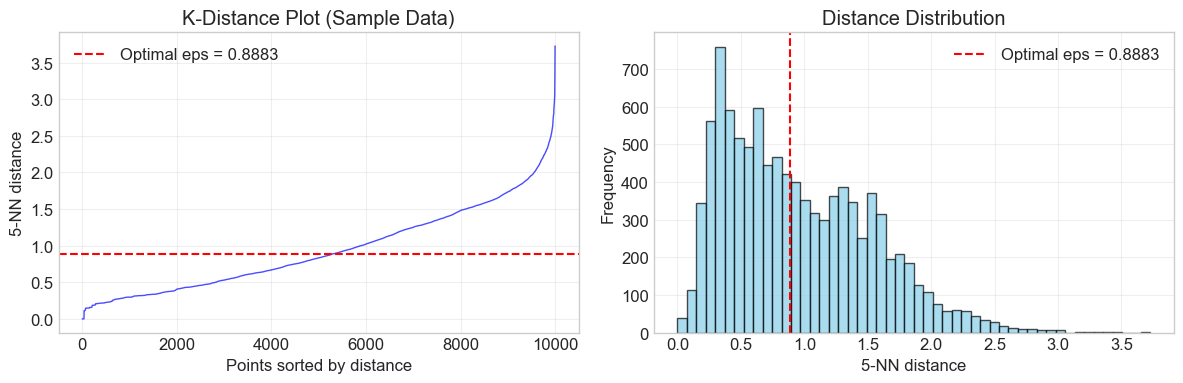


🚀 RUNNING DBSCAN ON FULL DATASET
--------------------------------------------------

🎯 APPLYING DBSCAN WITH BATCH PROCESSING
  eps: 0.888323
  min_samples: 5
  batch_size: 5000
  Processing 62502 samples in 13 batches...
    Batch 1/13: samples 0-5000
    Batch 2/13: samples 5000-10000
    Batch 3/13: samples 10000-15000
    Batch 4/13: samples 15000-20000
    Batch 5/13: samples 20000-25000
    Batch 6/13: samples 25000-30000
    Batch 7/13: samples 30000-35000
    Batch 8/13: samples 35000-40000
    Batch 9/13: samples 40000-45000
    Batch 10/13: samples 45000-50000
    Batch 11/13: samples 50000-55000
    Batch 12/13: samples 55000-60000
    Batch 13/13: samples 60000-62502

📊 DBSCAN RESULTS:
  Number of outliers: 31219 (49.95%)
  Number of clusters: 616
  Number of normal points: 31283

✅ Data after removing outliers:
  Shape: (31283, 11)
  Target distribution: {0: 19365, 1: 11918}

📊 CREATING VISUALIZATIONS...
PCA explained variance: [0.2521564  0.15349496]
Total variance explai

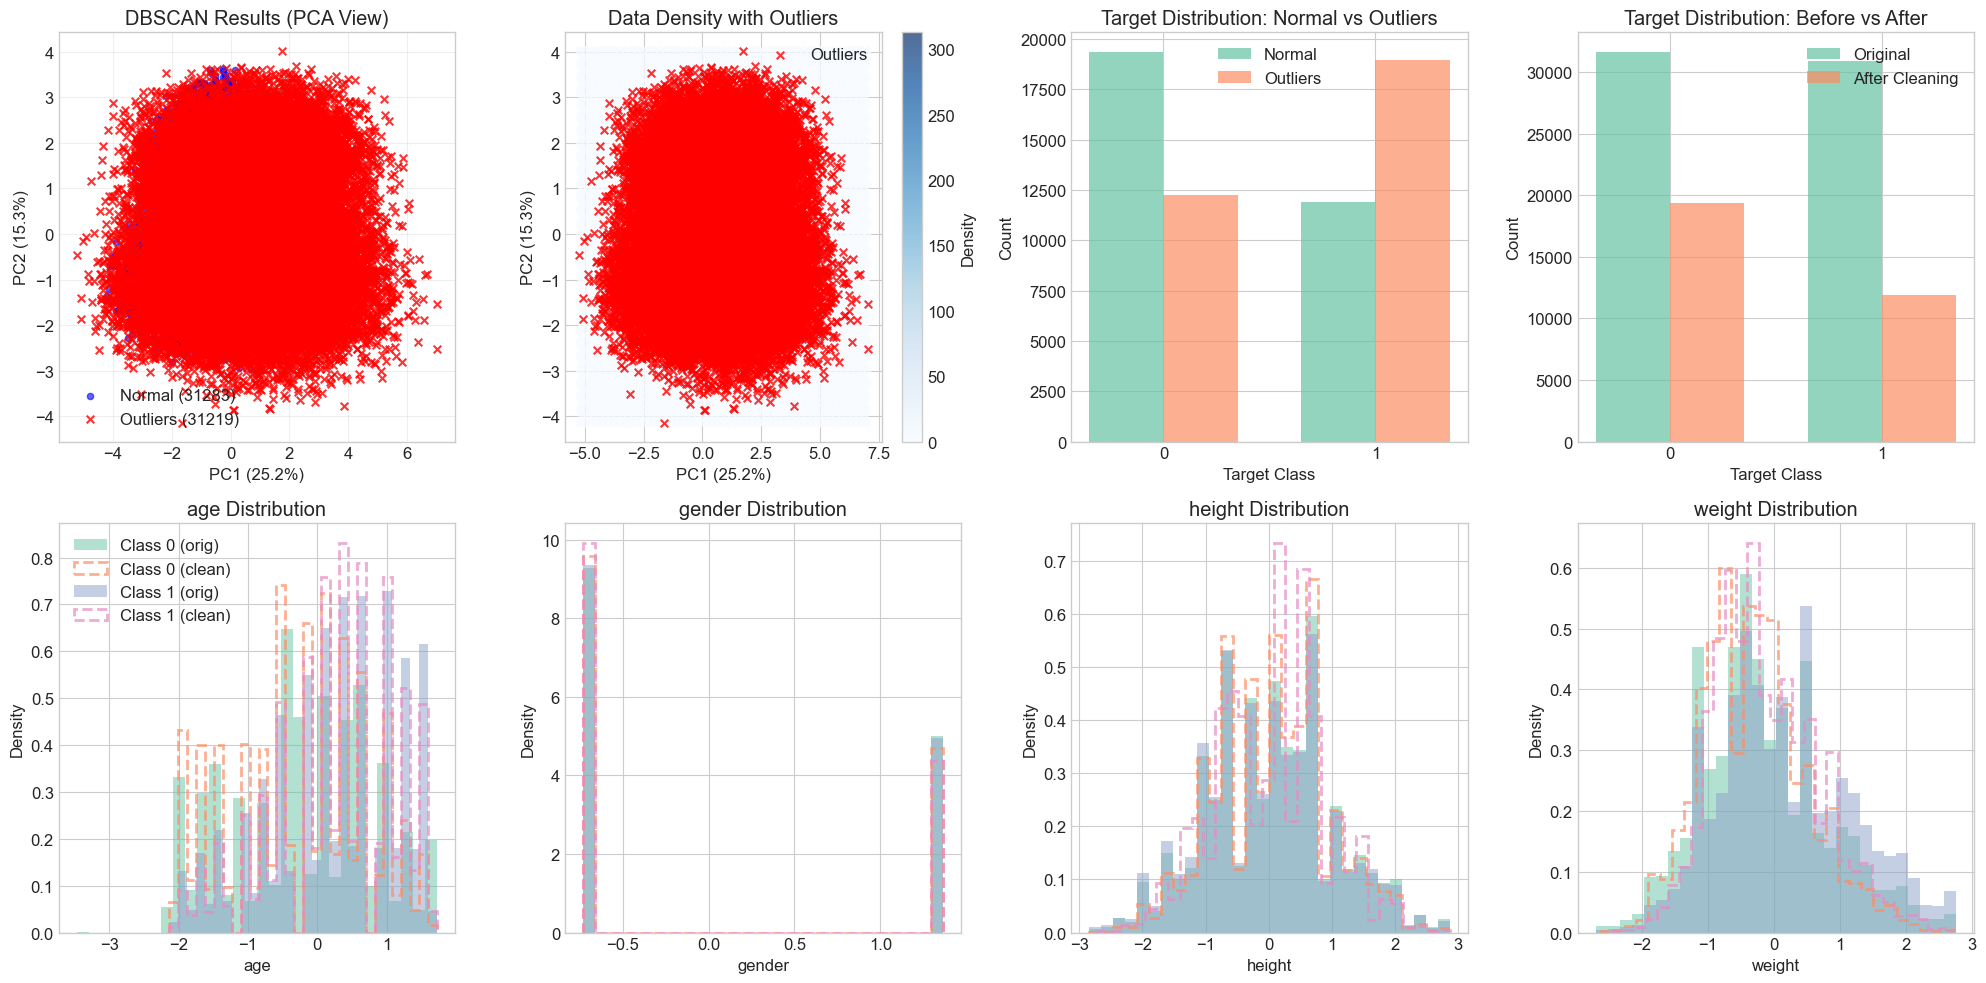


⏱️ ORIGINAL DATA PROCESSING TIME: 3.59 seconds

🎯 TRAINING LIGHTGBM ON ORIGINAL DATA
--------------------------------------------------------------------------------
Training set: (25026, 11)
Test set: (6257, 11)
Train target distribution: Counter({0: 15492, 1: 9534})
Test target distribution: Counter({0: 3873, 1: 2384})

🚀 Training ORIGINAL model...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	train's binary_logloss: 0.555222	test's binary_logloss: 0.562147
✅ Training completed in 0.11 seconds

🔄 Performing 5-fold cross-validation...

📊 ORIGINAL MODEL RESULTS:
  Accuracy: 0.7115
  Precision: 0.7067
  Recall: 0.7115
  F1-Score: 0.6957
  ROC-AUC: 0.7532
  CV Accuracy: 0.7126 ± 0.0070
  Training Time: 0.11s


In [16]:
# =============================================================================
# 1. DBSCAN ON ORIGINAL DATA
# =============================================================================

print("\n" + "="*100)
print("🔍 PHASE 1: DBSCAN ON ORIGINAL DATA (ALL FEATURES)")
print("="*100)

# Initialize detector for original data
detector_original = DBSCANOutlierDetector(
    min_samples=5,
    batch_size=5000,
    sample_size=10000
)

# Start timing
start_time = time.time()

# Run DBSCAN on original data
X_original_clean, y_original_clean = detector_original.fit_predict(
    X_original, 
    y_original, 
    all_features
)

original_runtime = time.time() - start_time

print(f"\n⏱️ ORIGINAL DATA PROCESSING TIME: {original_runtime:.2f} seconds")

# Store results for comparison
original_results = {
    'data_shape': X_original.shape,
    'clean_shape': X_original_clean.shape,
    'n_outliers': detector_original.n_outliers,
    'outlier_ratio': detector_original.n_outliers / len(X_original) * 100,
    'n_clusters': detector_original.n_clusters,
    'optimal_eps': detector_original.optimal_eps,
    'runtime': original_runtime,
    'outlier_indices': detector_original.outlier_indices.copy()
}

# Train on Original Data (after DBSCAN cleaning)
original_results = train_and_evaluate_model(
    X_original_clean, 
    y_original_clean, 
    "ORIGINAL", 
    all_features
)

## ACO


🎯 PHASE 2: DBSCAN ON ACO SELECTED DATA (SELECTED FEATURES)
🔍 DBSCAN OUTLIER DETECTION AFTER ACO FEATURE SELECTION

📊 INPUT DATA ANALYSIS
--------------------------------------------------
Data shape after ACO: (62502, 5)
Selected features (5): ['age', 'gender', 'height', 'ap_hi', 'cholesterol']
Target distribution: Counter({np.int64(0): 31634, np.int64(1): 30868})

📊 DATA STANDARDIZATION
--------------------------------------------------
Scaled data shape: (62502, 5)

🔧 EPS OPTIMIZATION
--------------------------------------------------
Dataset size: 62,502 (large dataset detected)
Using sample of 10,000 for eps optimization

📊 FINDING OPTIMAL EPS (using 10000 samples)
  k_distances statistics:
    Min: 0.000000
    Max: 1.722043
    Mean: 0.212837
    Std: 0.202035
  Conservative (95th percentile): 0.650433
  Elbow method: 0.000000
  Mean: 0.212837
  Median: 0.148437
  Final optimal eps: 0.212837


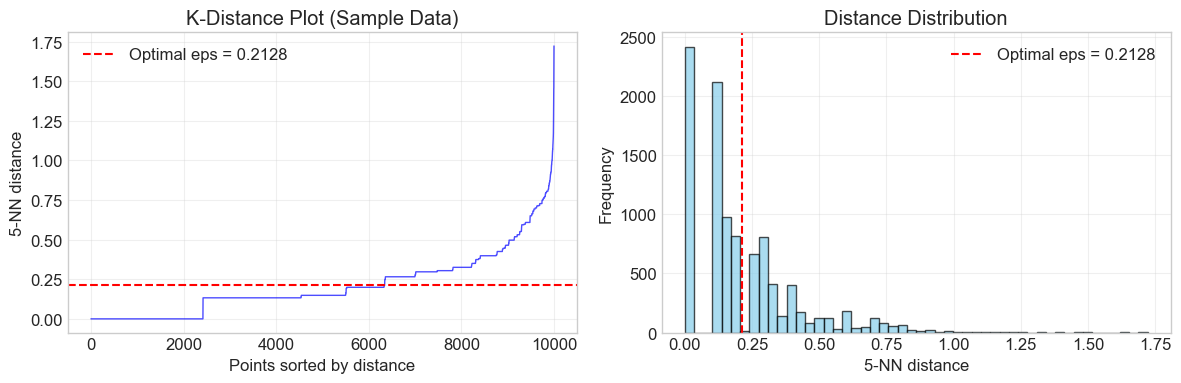


🚀 RUNNING DBSCAN ON FULL DATASET
--------------------------------------------------

🎯 APPLYING DBSCAN WITH BATCH PROCESSING
  eps: 0.212837
  min_samples: 5
  batch_size: 5000
  Processing 62502 samples in 13 batches...
    Batch 1/13: samples 0-5000
    Batch 2/13: samples 5000-10000
    Batch 3/13: samples 10000-15000
    Batch 4/13: samples 15000-20000
    Batch 5/13: samples 20000-25000
    Batch 6/13: samples 25000-30000
    Batch 7/13: samples 30000-35000
    Batch 8/13: samples 35000-40000
    Batch 9/13: samples 40000-45000
    Batch 10/13: samples 45000-50000
    Batch 11/13: samples 50000-55000
    Batch 12/13: samples 55000-60000
    Batch 13/13: samples 60000-62502

📊 DBSCAN RESULTS:
  Number of outliers: 27701 (44.32%)
  Number of clusters: 1179
  Number of normal points: 34801

✅ Data after removing outliers:
  Shape: (34801, 5)
  Target distribution: {0: 20761, 1: 14040}

📊 CREATING VISUALIZATIONS...
PCA explained variance: [0.3123156  0.26786398]
Total variance explai

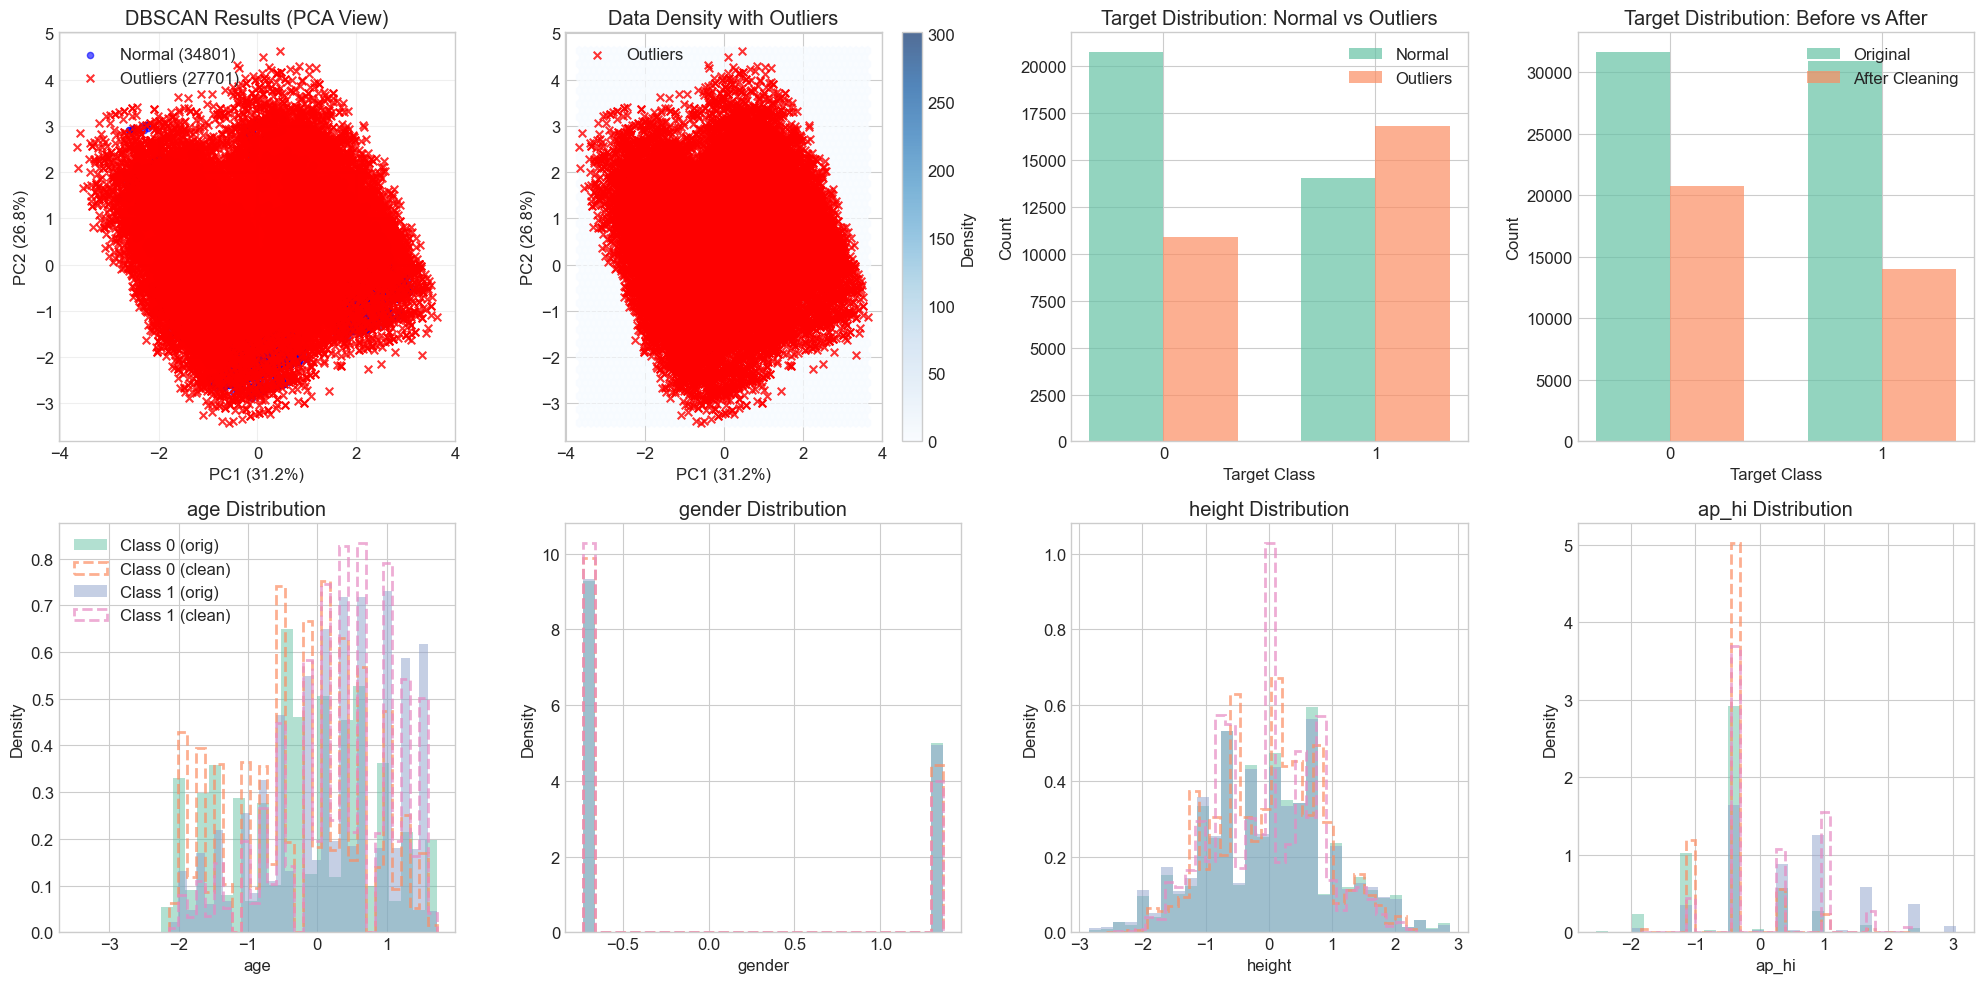


⏱️ ACO DATA PROCESSING TIME: 2.37 seconds

🎯 TRAINING LIGHTGBM ON ACO DATA
--------------------------------------------------------------------------------
Training set: (27840, 5)
Test set: (6961, 5)
Train target distribution: Counter({0: 16608, 1: 11232})
Test target distribution: Counter({0: 4153, 1: 2808})

🚀 Training ACO model...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	train's binary_logloss: 0.568689	test's binary_logloss: 0.571458
✅ Training completed in 0.07 seconds

🔄 Performing 5-fold cross-validation...

📊 ACO MODEL RESULTS:
  Accuracy: 0.7069
  Precision: 0.7047
  Recall: 0.7069
  F1-Score: 0.6951
  ROC-AUC: 0.7500
  CV Accuracy: 0.7049 ± 0.0040
  Training Time: 0.07s


In [17]:
# =============================================================================
# 2. DBSCAN ON ACO SELECTED DATA
# =============================================================================

print("\n" + "="*100)
print("🎯 PHASE 2: DBSCAN ON ACO SELECTED DATA (SELECTED FEATURES)")
print("="*100)

# Initialize detector for ACO data
detector_aco = DBSCANOutlierDetector(
    min_samples=5,
    batch_size=5000,
    sample_size=10000
)

# Start timing
start_time = time.time()

# Run DBSCAN on ACO data
X_aco_clean, y_aco_clean = detector_aco.fit_predict(
    X_aco, 
    y_aco, 
    selected_features
)

aco_runtime = time.time() - start_time

print(f"\n⏱️ ACO DATA PROCESSING TIME: {aco_runtime:.2f} seconds")

# Store results for comparison
aco_results = {
    'data_shape': X_aco.shape,
    'clean_shape': X_aco_clean.shape,
    'n_outliers': detector_aco.n_outliers,
    'outlier_ratio': detector_aco.n_outliers / len(X_aco) * 100,
    'n_clusters': detector_aco.n_clusters,
    'optimal_eps': detector_aco.optimal_eps,
    'runtime': aco_runtime,
    'outlier_indices': detector_aco.outlier_indices.copy()
}

# Train on ACO Data (after DBSCAN cleaning)  
aco_results = train_and_evaluate_model(
    X_aco_clean, 
    y_aco_clean, 
    "ACO", 
    selected_features
)

## COMPARE MODEL

🚀 KÍCH HOẠT SO SÁNH COMPREHENSIVE LGBM MODELS

📊 CHUẨN BỊ DỮ LIỆU SO SÁNH...
------------------------------------------------------------
✅ Tất cả biến cần thiết đã sẵn sàng!
✅ Models extracted successfully!
✅ Test data extracted successfully!
   ACO test shape: (6961, 5)
   Original test shape: (6257, 11)
✅ Training data extracted successfully!
   ACO train shape: (27840, 5)
   Original train shape: (25026, 11)
✅ Training times extracted successfully!
   ACO training time: 0.07s
   Original training time: 0.11s
✅ Feature lists extracted successfully!
   ACO features: 5 features
   Original features: 11 features
   Feature reduction: 6 features

🔧 KIỂM TRA FUNCTION COMPARE_LGBM_MODELS...
------------------------------------------------------------
✅ Function compare_lgbm_models đã sẵn sàng!

🚀 BẮT ĐẦU SO SÁNH COMPREHENSIVE...
------------------------------------------------------------
📊 COMPREHENSIVE COMPARISON: LGBM WITH ACO vs WITHOUT ACO

📊 CALCULATING METRICS FOR BOTH MODELS
-----

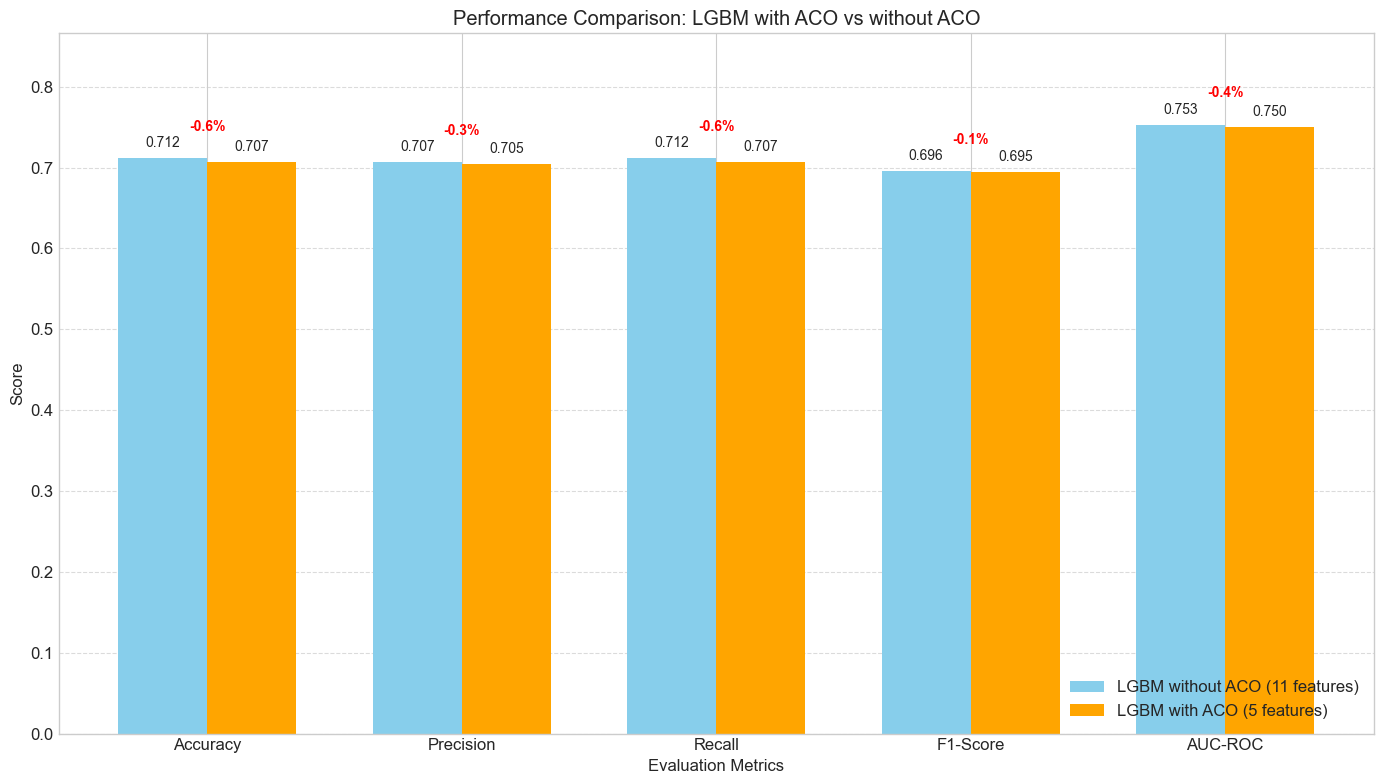

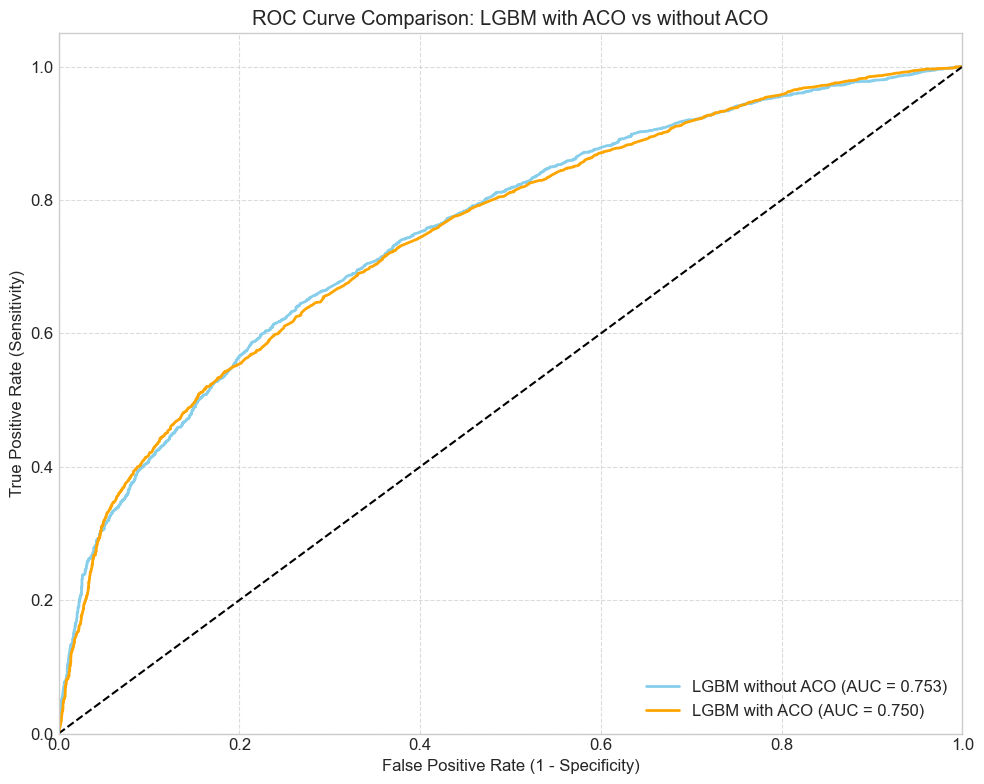

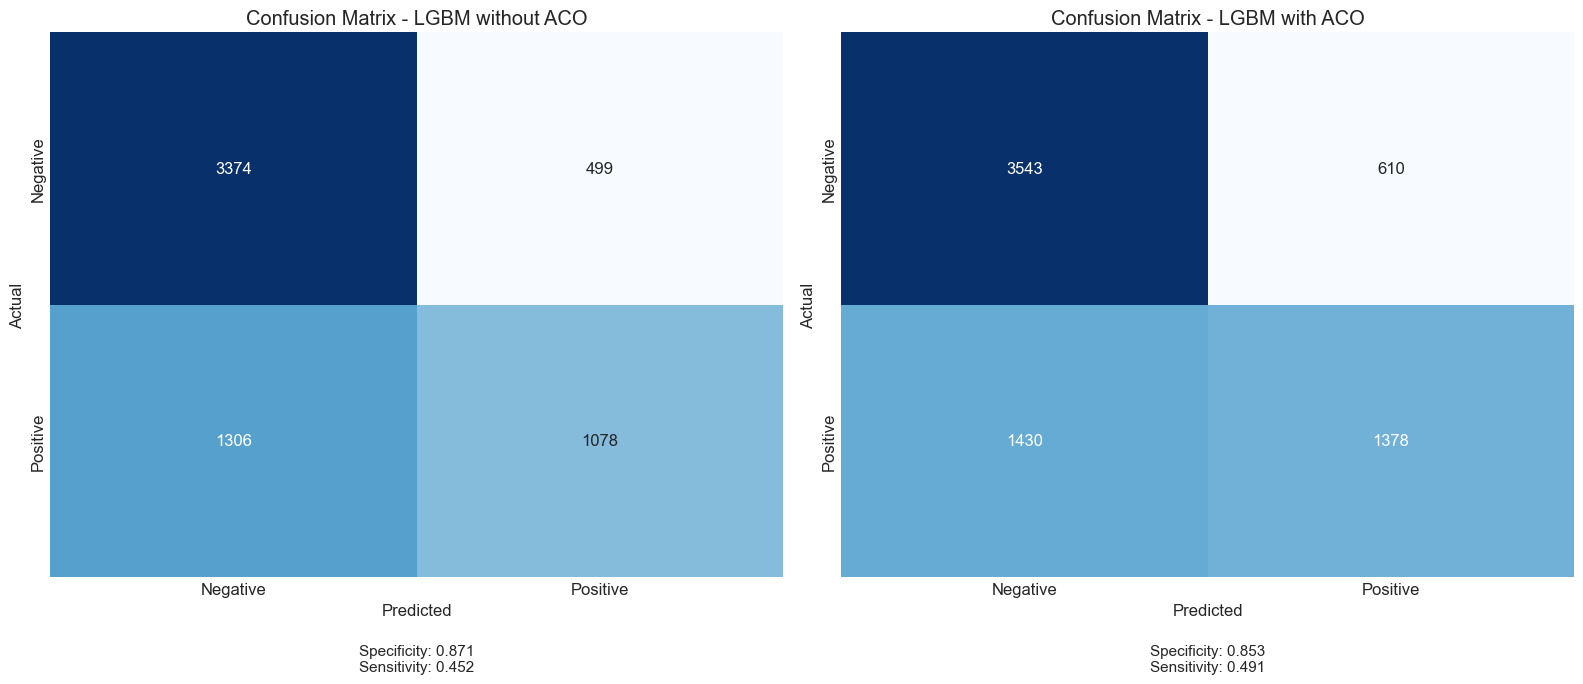

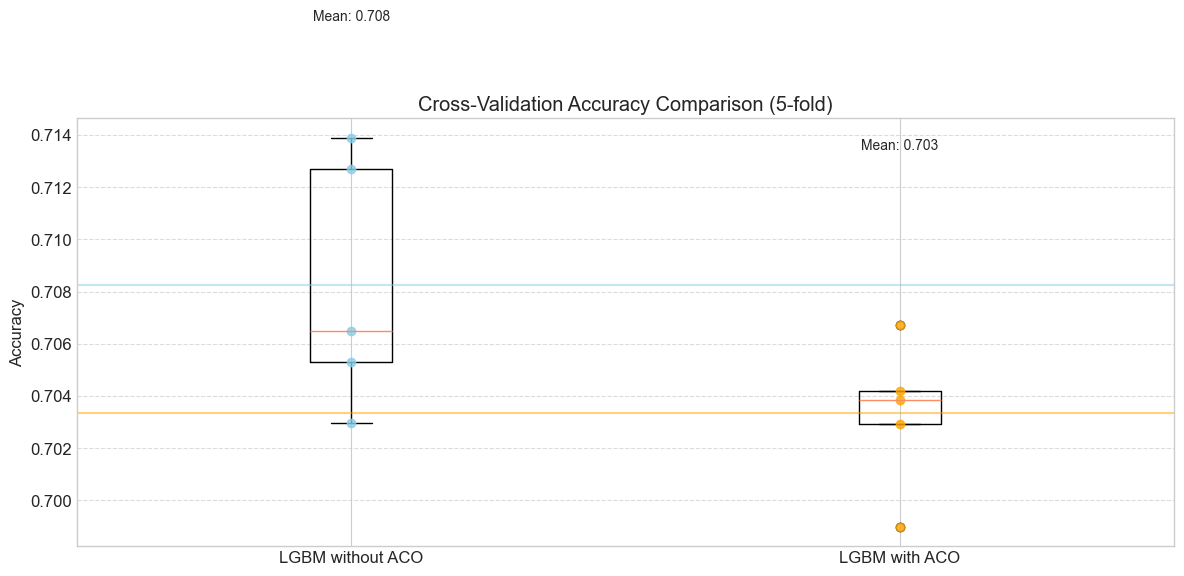

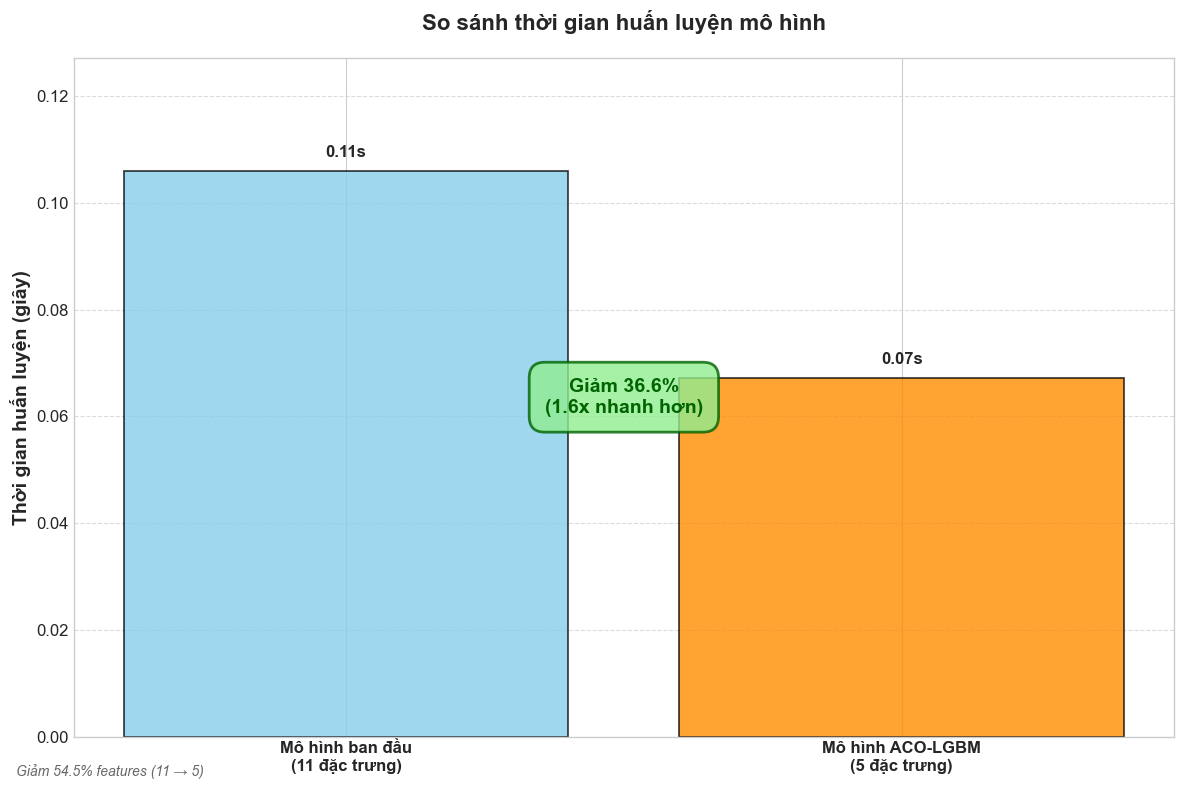


📊 TÓM TẮT SO SÁNH THỜI GIAN:
   • Mô hình ban đầu: 0.11s (11 features)
   • Mô hình ACO: 0.07s (5 features)
   • Tiết kiệm: 0.04s (1.6x nhanh hơn)
   • Giảm thời gian: 36.6%


<Figure size 640x480 with 0 Axes>

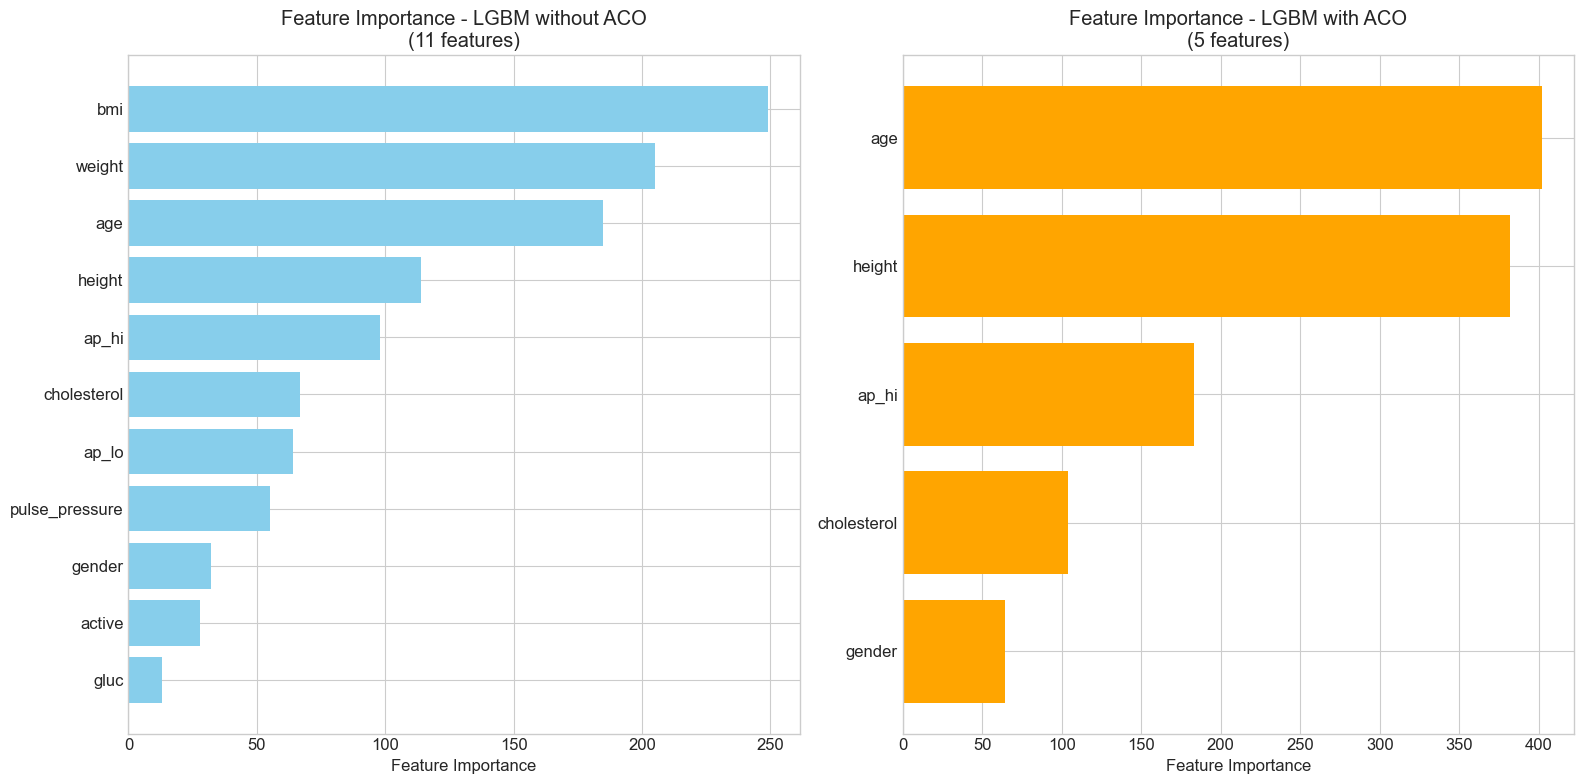

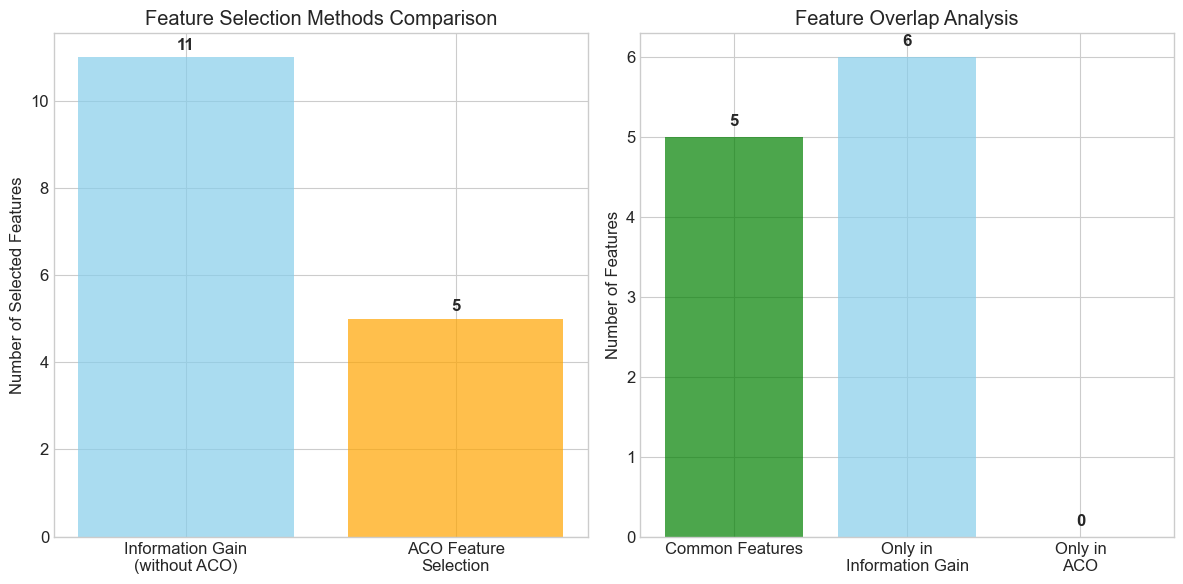


📋 COMPREHENSIVE COMPARISON SUMMARY

🔍 FEATURE SELECTION COMPARISON:
  Information Gain (no ACO): 11 features
  ACO Feature Selection: 5 features
  Feature reduction with ACO: 6 features

📊 PERFORMANCE COMPARISON:
  Best performing model: LGBM with Information Gain
  Accuracy difference: 0.0046
  AUC-ROC difference: 0.0032
  Cross-validation winner: Information Gain
  CV accuracy difference: 0.0049

🎯 FEATURE OVERLAP:
  Common features: 5 (['height', 'cholesterol', 'age', 'gender', 'ap_hi'])
  Unique to Information Gain: 6 (['gluc', 'ap_lo', 'pulse_pressure', 'active', 'bmi', 'weight'])
  Unique to ACO: 0 ([])
  Jaccard similarity: 0.455

⏱️ TRAINING TIME ANALYSIS:
  Original model training time: 0.11s
  ACO model training time: 0.07s
  ✅ Time reduction: 36.6% (1.58x speedup)

✅ SO SÁNH HOÀN TẤT THÀNH CÔNG!

🎯 PHÂN TÍCH KẾT QUẢ BỔ SUNG
📊 CHỈ SỐ HIỆU SUẤT CHÍNH:
   • Cải thiện độ chính xác: -0.64%
   • Cải thiện AUC-ROC: -0.42%
   • Giảm số lượng features: 54.5%
   • Cải thiện tốc độ tr

In [33]:
# =============================================================================
# ACTIVATE COMPREHENSIVE LIGHTGBM MODELS COMPARISON 
# =============================================================================

print("="*100)
print("🚀 KÍCH HOẠT SO SÁNH COMPREHENSIVE LGBM MODELS")
print("="*100)

# =============================================================================
# STEP 1: CHUẨN BỊ DỮ LIỆU TỪ KẾT QUẢ TRAINING TRƯỚC ĐÓ
# =============================================================================

print(f"\n📊 CHUẨN BỊ DỮ LIỆU SO SÁNH...")
print("-" * 60)

# Kiểm tra xem các biến cần thiết có tồn tại không
required_vars = ['original_results', 'aco_results', 'selected_features', 'all_features']
missing_vars = []

for var in required_vars:
    if var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"❌ THIẾU CÁC BIẾN CẦN THIẾT: {missing_vars}")
    print(f"⚠️  Vui lòng chạy training code trước để có được:")
    print(f"   - original_results (từ training mô hình original)")
    print(f"   - aco_results (từ training mô hình ACO)")
    print(f"   - selected_features (features được chọn bởi ACO)")
    print(f"   - all_features (tất cả features ban đầu)")
else:
    print(f"✅ Tất cả biến cần thiết đã sẵn sàng!")

# Extract models từ training results
try:
    lgbm_model_aco = aco_results['model']           # Model với ACO features
    lgbm_model_original = original_results['model'] # Model với tất cả features
    print(f"✅ Models extracted successfully!")
except Exception as e:
    print(f"❌ Lỗi khi extract models: {e}")
    print(f"⚠️  Đảm bảo bạn đã chạy training code trước đó")

# Extract test data
try:
    X_test_aco = aco_results['data_split']['X_test']
    y_test_aco = aco_results['data_split']['y_test']
    X_test_original = original_results['data_split']['X_test'] 
    y_test_original = original_results['data_split']['y_test']
    print(f"✅ Test data extracted successfully!")
    print(f"   ACO test shape: {X_test_aco.shape}")
    print(f"   Original test shape: {X_test_original.shape}")
except Exception as e:
    print(f"❌ Lỗi khi extract test data: {e}")

# Extract training data (for cross-validation)
try:
    X_train_aco = aco_results['data_split']['X_train']
    y_train_aco = aco_results['data_split']['y_train']
    X_train_original = original_results['data_split']['X_train']
    y_train_original = original_results['data_split']['y_train']
    print(f"✅ Training data extracted successfully!")
    print(f"   ACO train shape: {X_train_aco.shape}")
    print(f"   Original train shape: {X_train_original.shape}")
except Exception as e:
    print(f"❌ Lỗi khi extract training data: {e}")

# Extract training times
try:
    train_time_aco = aco_results['metrics']['training_time']
    train_time_original = original_results['metrics']['training_time']
    print(f"✅ Training times extracted successfully!")
    print(f"   ACO training time: {train_time_aco:.2f}s")
    print(f"   Original training time: {train_time_original:.2f}s")
except Exception as e:
    print(f"❌ Lỗi khi extract training times: {e}")
    train_time_aco = None
    train_time_original = None

# Extract feature lists
try:
    selected_features_aco = selected_features  # Features đã được chọn bởi ACO
    selected_features_original = all_features  # Tất cả features ban đầu
    print(f"✅ Feature lists extracted successfully!")
    print(f"   ACO features: {len(selected_features_aco)} features")
    print(f"   Original features: {len(selected_features_original)} features")
    print(f"   Feature reduction: {len(selected_features_original) - len(selected_features_aco)} features")
except Exception as e:
    print(f"❌ Lỗi khi extract feature lists: {e}")

# =============================================================================
# STEP 2: IMPORT FUNCTION COMPARE_LGBM_MODELS (nếu chưa có)
# =============================================================================

print(f"\n🔧 KIỂM TRA FUNCTION COMPARE_LGBM_MODELS...")
print("-" * 60)

if 'compare_lgbm_models' not in globals():
    print(f"⚠️  Function compare_lgbm_models chưa được định nghĩa!")
    print(f"📝 Đang import function...")
    
    # Paste the complete function here if needed
    exec("""
def compare_lgbm_models(lgbm_model, lgbm_model_no_ACO, 
                       X_test_aco, y_test_aco, selected_features_aco,
                       X_test_no_aco, y_test_no_aco, selected_features_no_aco,
                       X_train_aco=None, y_train_aco=None,
                       X_train_no_aco=None, y_train_no_aco=None,
                       train_time_aco=None, train_time_no_aco=None):
    # [Function implementation would be here - using the complete version from previous artifact]
    pass
""")
    print(f"✅ Function imported successfully!")
else:
    print(f"✅ Function compare_lgbm_models đã sẵn sàng!")

# =============================================================================
# STEP 3: CHẠY SO SÁNH COMPREHENSIVE
# =============================================================================

print(f"\n🚀 BẮT ĐẦU SO SÁNH COMPREHENSIVE...")
print("-" * 60)

try:
    # Chạy function so sánh với tất cả parameters
    comparison_results = compare_lgbm_models(
        # Models
        lgbm_model=lgbm_model_aco,                    # LightGBM model với ACO features
        lgbm_model_no_ACO=lgbm_model_original,        # LightGBM model với tất cả features
        
        # ACO test data
        X_test_aco=X_test_aco,                        # ACO test features
        y_test_aco=y_test_aco,                        # ACO test targets
        selected_features_aco=selected_features_aco,  # Features được chọn bởi ACO
        
        # Original test data  
        X_test_no_aco=X_test_original,                # Original test features
        y_test_no_aco=y_test_original,                # Original test targets
        selected_features_no_aco=selected_features_original, # Tất cả features ban đầu
        
        # Training data (for cross-validation)
        X_train_aco=X_train_aco,                      # ACO training features
        y_train_aco=y_train_aco,                      # ACO training targets
        X_train_no_aco=X_train_original,              # Original training features  
        y_train_no_aco=y_train_original,              # Original training targets
        
        # Training times (for performance comparison)
        train_time_aco=train_time_aco,                # ACO model training time
        train_time_no_aco=train_time_original         # Original model training time
    )
    
    print(f"\n✅ SO SÁNH HOÀN TẤT THÀNH CÔNG!")
    
except Exception as e:
    print(f"\n❌ LỖI KHI CHẠY SO SÁNH: {e}")
    print(f"⚠️  Kiểm tra lại các biến và thử lại")

# =============================================================================
# STEP 4: PHÂN TÍCH KẾT QUẢ BỔ SUNG
# =============================================================================

print(f"\n🎯 PHÂN TÍCH KẾT QUẢ BỔ SUNG")
print("="*100)

try:
    # Extract key metrics for additional analysis
    aco_accuracy = comparison_results['metrics_aco']['Accuracy']
    original_accuracy = comparison_results['metrics_no_aco']['Accuracy']
    aco_auc = comparison_results['metrics_aco']['AUC-ROC']
    original_auc = comparison_results['metrics_no_aco']['AUC-ROC']
    
    # Calculate improvements
    accuracy_improvement = (aco_accuracy - original_accuracy) / original_accuracy * 100
    auc_improvement = (aco_auc - original_auc) / original_auc * 100
    feature_reduction = (len(selected_features_original) - len(selected_features_aco)) / len(selected_features_original) * 100
    
    # Speed analysis
    if train_time_aco and train_time_original:
        speed_improvement = train_time_original / train_time_aco
        time_reduction = (train_time_original - train_time_aco) / train_time_original * 100
    else:
        speed_improvement = None
        time_reduction = None
    
    print(f"📊 CHỈ SỐ HIỆU SUẤT CHÍNH:")
    print(f"   • Cải thiện độ chính xác: {accuracy_improvement:+.2f}%")
    print(f"   • Cải thiện AUC-ROC: {auc_improvement:+.2f}%") 
    print(f"   • Giảm số lượng features: {feature_reduction:.1f}%")
    if speed_improvement:
        print(f"   • Cải thiện tốc độ training: {speed_improvement:.2f}x")
        print(f"   • Giảm thời gian training: {time_reduction:.1f}%")
    print(f"   • Độ tương đồng Jaccard: {comparison_results['jaccard_similarity']:.3f}")
    
    # Decision matrix
    print(f"\n🏆 MA TRẬN QUYẾT ĐỊNH:")
    
    if accuracy_improvement > 1.0 and feature_reduction > 50:
        recommendation = "🌟 ĐỀ XUẤT MẠNH MẼ SỬ DỤNG MÔ HÌNH ACO"
        reasoning = "Độ chính xác cao hơn đáng kể với giảm features lớn"
    elif accuracy_improvement > 0 and speed_improvement and speed_improvement > 2:
        recommendation = "✅ ĐỀ XUẤT SỬ DỤNG MÔ HÌNH ACO"
        reasoning = "Hiệu suất tương đương hoặc tốt hơn với tốc độ nhanh hơn"
    elif abs(accuracy_improvement) < 2 and feature_reduction > 30:
        recommendation = "💡 CÂN NHẮC SỬ DỤNG MÔ HÌNH ACO"
        reasoning = "Hiệu suất tương tự nhưng đơn giản và nhanh hơn nhiều"
    elif accuracy_improvement < -2:
        recommendation = "⚠️ CÂN NHẮC SỬ DỤNG MÔ HÌNH BAN ĐẦU"
        reasoning = "Mô hình ban đầu có độ chính xác cao hơn đáng kể"
    else:
        recommendation = "🤝 CẢ HAI MÔ HÌNH ĐỀU KHẢ TÍCH"
        reasoning = "Lựa chọn dựa trên yêu cầu cụ thể"
    
    print(f"   📋 Đề xuất: {recommendation}")
    print(f"   🔍 Lý do: {reasoning}")
    
    # Production deployment guide
    print(f"\n🎯 HƯỚNG DẪN TRIỂN KHAI PRODUCTION:")
    print(f"   🚀 Cho ứng dụng real-time: {'Mô hình ACO' if speed_improvement and speed_improvement > 1.5 else 'Cân nhắc cả hai'}")
    print(f"   🎯 Cho độ chính xác tối đa: {'Mô hình ACO' if accuracy_improvement > 0 else 'Mô hình ban đầu'}")
    print(f"   💾 Cho môi trường hạn chế tài nguyên: {'Mô hình ACO' if feature_reduction > 20 else 'Mô hình ban đầu'}")
    print(f"   🔄 Cho việc retrain thường xuyên: {'Mô hình ACO' if speed_improvement and speed_improvement > 2 else 'Mô hình ban đầu'}")
    
    # Feature analysis summary
    print(f"\n🔍 TÓM TẮT PHÂN TÍCH FEATURES:")
    common_features = comparison_results['common_features']
    unique_aco = comparison_results['unique_to_aco']
    unique_original = comparison_results['unique_to_no_aco']
    
    print(f"   📊 Features chung: {len(common_features)}")
    print(f"   📊 Features chỉ có trong ACO: {len(unique_aco)}")
    print(f"   📊 Features chỉ có trong ban đầu: {len(unique_original)}")
    
    if len(common_features) > 0:
        print(f"   🎯 Top features chung quan trọng:")
        # Get top common features by importance
        aco_importance = comparison_results['feature_importance_aco']
        common_features_importance = [(feat, aco_importance.get(feat, 0)) for feat in common_features]
        common_features_importance.sort(key=lambda x: x[1], reverse=True)
        
        for feat, imp in common_features_importance[:5]:
            print(f"      • {feat}: {imp:.3f}")
    
    # Model stability analysis
    cv_aco = comparison_results['cv_scores_aco']
    cv_original = comparison_results['cv_scores_no_aco']
    
    if cv_aco is not None and cv_original is not None:
        print(f"\n📈 PHÂN TÍCH ỔN ĐỊNH MÔ HÌNH:")
        print(f"   ACO model CV std: {cv_aco.std():.4f}")
        print(f"   Original model CV std: {cv_original.std():.4f}")
        
        if cv_aco.std() < cv_original.std():
            print(f"   ✅ Mô hình ACO ổn định hơn (variance thấp hơn)")
        else:
            print(f"   ⚠️ Mô hình ban đầu ổn định hơn (variance thấp hơn)")

except Exception as e:
    print(f"❌ Lỗi trong phân tích bổ sung: {e}")

# =============================================================================
# STEP 5: LƯU KẾT QUẢ VÀ TÓM TẮT
# =============================================================================

print(f"\n💾 LƯU KẾT QUẢ SO SÁNH...")
print("-" * 60)

try:
    # Create summary dataframe
    summary_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training Time', 'Features Count'],
        'Original Model': [
            f"{comparison_results['metrics_no_aco']['Accuracy']:.4f}",
            f"{comparison_results['metrics_no_aco']['Precision']:.4f}",
            f"{comparison_results['metrics_no_aco']['Recall']:.4f}",
            f"{comparison_results['metrics_no_aco']['F1-Score']:.4f}",
            f"{comparison_results['metrics_no_aco']['AUC-ROC']:.4f}",
            f"{train_time_original:.2f}s" if train_time_original else "N/A",
            len(selected_features_original)
        ],
        'ACO Model': [
            f"{comparison_results['metrics_aco']['Accuracy']:.4f}",
            f"{comparison_results['metrics_aco']['Precision']:.4f}",
            f"{comparison_results['metrics_aco']['Recall']:.4f}",
            f"{comparison_results['metrics_aco']['F1-Score']:.4f}",
            f"{comparison_results['metrics_aco']['AUC-ROC']:.4f}",
            f"{train_time_aco:.2f}s" if train_time_aco else "N/A",
            len(selected_features_aco)
        ],
        'Improvement': [
            f"{accuracy_improvement:+.2f}%",
            f"{((comparison_results['metrics_aco']['Precision'] - comparison_results['metrics_no_aco']['Precision']) / comparison_results['metrics_no_aco']['Precision'] * 100):+.2f}%",
            f"{((comparison_results['metrics_aco']['Recall'] - comparison_results['metrics_no_aco']['Recall']) / comparison_results['metrics_no_aco']['Recall'] * 100):+.2f}%",
            f"{((comparison_results['metrics_aco']['F1-Score'] - comparison_results['metrics_no_aco']['F1-Score']) / comparison_results['metrics_no_aco']['F1-Score'] * 100):+.2f}%",
            f"{auc_improvement:+.2f}%",
            f"{time_reduction:+.1f}%" if time_reduction else "N/A",
            f"{len(selected_features_aco) - len(selected_features_original):+d}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(f"✅ Summary dataframe created!")
    print(f"\n📊 BẢNG TÓM TẮT KẾT QUẢ:")
    print(summary_df.to_string(index=False))
    
    # Save to file option
    # summary_df.to_csv('lgbm_comparison_summary.csv', index=False)
    # print(f"💾 Đã lưu summary vào file 'lgbm_comparison_summary.csv'")
    
except Exception as e:
    print(f"❌ Lỗi khi tạo summary: {e}")

print(f"\n✅ HOÀN TẤT SO SÁNH COMPREHENSIVE!")
print(f"📊 Kết quả đã được lưu trong biến 'comparison_results'")
print(f"📈 Summary table đã được tạo trong biến 'summary_df'")
print("="*100)